# Trends

Look at trends in taxi/rideshare use over the last few rounds of the NHTS.

Author: Matthew Wigginton Conway <matt@indicatrix.org>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from functools import partial
import scipy.stats
from matplotlib.ticker import FuncFormatter
from nhts import estReplicateSE, multiReplicateSE
import textwrap

sys.path.append('/Users/matthewc/Dropbox (Personal)/python_dev')
%aimport mattwigway.math

In [2]:
TAXI_COLOR = '#77bb77'
GENERAL_COLOR = '#aaaaff'

## Define weighting variables

The weight variables have slightly different names over the years. The travel day weights are a simple function of the person weights, so use person weights for everything. This is valid, since all travel day variables we examine are used in proportions.

In [3]:
WEIGHTS = {
    1995: 'WTPERFIN',
    2001: 'WTPERFIN',
    2009: 'WTPERFIN',
    2017: 'WTPERFIN'
}

REP_WEIGHTS = {
    1995: 'WTPERFIN',
    2001: 'WTPFIN', # damn it were they paying by the letter?
    2009: 'WTPERFIN',
    2017: 'WTPERFIN'
}

## Define a function to parse the fixed-width 1995 NHTS files

The 1995 NHTS uses fixed-width files with separate schemas. The function below parses such files, using schemas converted to CSV format through importing to Excel and making a few manual tweaks.

In [4]:
def parseNhtsFixedWidth (filename, schemaname):
    schema = pd.read_csv(schemaname)
    # Convert from 1-based indexing to 0-based. No need to do at end because end in schema file is inclusive, while
    # pandas expects an exclusive end
    if 'Start' in schema.columns:
        colspecs = schema.apply(lambda x: (x.Start - 1, x.End), 1).values.tolist()
        data = pd.read_fwf(filename, colspecs=colspecs, names=schema['Field Name'])
    else:
        data = pd.read_fwf(filename, widths=schema.Width, names=schema['Field Name'])
    return data

## Read data

We have data from the 1983, 1990, and 1995 NPTS and the 2001, 2009 and 2017 NHTS. It turns out though that the 1983 and 1990 weren't very useful. All years since 2001 have replicate weights for standard error estimation, which are provided in separate files, so we pull those in as well and join them.

In [5]:
trips17 = pd.read_csv('../data/2017/trippub.csv')
repl17 = pd.read_csv('../data/2017/perwgt.csv')
trips17 = trips17.merge(repl17.drop(['WTTRDFIN'], 1), on=['HOUSEID', 'PERSONID'], how='left', validate='m:1')
pers17 = pd.read_csv('../data/2017/perpub.csv')
pers17 = pers17.merge(repl17.drop(['WTPERFIN'], 1), on=['HOUSEID', 'PERSONID'], how='left', validate='m:1')

In [6]:
trips09 = pd.read_csv('../data/2009/Ascii/DAYV2PUB.CSV')
repl09 = pd.read_csv('../data/2009/per50wt.csv')
trips09 = trips09.merge(repl09, on=['HOUSEID', 'PERSONID'], how='left', validate='m:1')
pers09 = pd.read_csv('../data/2009/Ascii/PERV2PUB.CSV')
pers09 = pers09.merge(repl09.drop(['WTPERFIN'], 1), on=['HOUSEID', 'PERSONID'], how='left', validate='m:1')

In [7]:
trips01 = pd.read_csv('../data/2001/DAYPUB.csv', low_memory=False)
repl01 = pd.read_csv('../data/2001/pr50wt.csv', low_memory=False)
trips01 = trips01.merge(repl01.drop(['WTTRDFIN'], 1), left_on=['HOUSEID', 'PERSONID'], right_on=['ID9', 'PERSONID'],
                        how='left', validate='m:1')
pers01 = pd.read_csv('../data/2001/PERPUB.CSV', low_memory=False)
pers01 = pers01.merge(repl01.drop(['WTPERFIN'], 1), left_on=['HOUSEID', 'PERSONID'], right_on=['ID9', 'PERSONID'],
                        how='left', validate='m:1')

In [8]:
trips95 = parseNhtsFixedWidth('../data/1995/dtrp95_2.txt', '../data/1995/dtrp95_2_schema.csv')
seg95 = parseNhtsFixedWidth('../data/1995/Segtrp95.txt', '../data/1995/Segtrp95_schema.csv')
pers95 = parseNhtsFixedWidth('../data/1995/PERS95_2.TXT', '../data/1995/PERS95_2_schema.csv')
trips95 = trips95.merge(pers95[['HOUSEID', 'PERSONID', 'WTPERFIN']], on=['HOUSEID', 'PERSONID'], how='left', validate='m:1')
pers95 = pers95.drop(index=[95360]) # there's a blank line at the end of the file
trips95 = trips95.drop(index=[409025]) # same

In [9]:
# Confirm that person and travel day weights are interchangeable when calculating proportions
assert np.all(np.abs(trips17.WTTRDFIN / trips17.WTPERFIN - 365) < 1e-6)
assert np.all(np.abs(trips09.WTTRDFIN / trips09.WTPERFIN - 365) < 1e-6)
assert np.all(np.abs(trips01.WTTRDFIN / trips01.WTPERFIN - 365) < 1e-6)
# less precise on this one, they rounded all weights to two decimal places (I guess storage was in short supply back then...)
assert np.all(np.abs(trips95.WTTRDFIN / trips95.WTPERFIN - 365) < 15)

## Identify taxi users

Add a 'taxi' flag to each person who used a taxi on the travel day in each year of the NHTS.

In [10]:
def addTaxiVar (trips, persons, taxiModeCode):
    didUseTaxi = trips.groupby(['HOUSEID', 'PERSONID'], as_index=False)\
        .TRPTRANS.agg(lambda x: np.any(x.isin(taxiModeCode)))
    didUseTaxi.rename(columns={'TRPTRANS': 'taxi'}, inplace=True)
    persons = persons.merge(didUseTaxi, on=['HOUSEID', 'PERSONID'], how='left', validate='1:1')

    # Handle zero-trip-makers
    persons.taxi.fillna(False, inplace=True)
    
    return persons

In [11]:
# The Taxi mode for each year
TAXI_MODE = {
    2017: [17],
    2009: [19],
    2001: [22, 23],
    1995: [15]
}

In [12]:
pers17 = addTaxiVar(trips17, pers17, TAXI_MODE[2017])
np.sum(pers17[pers17.taxi].WTPERFIN) / np.sum(pers17.WTPERFIN)

0.00937264449155716

In [13]:
pers09 = addTaxiVar(trips09, pers09, TAXI_MODE[2009])
np.sum(pers09[pers09.taxi].WTPERFIN) / np.sum(pers09.WTPERFIN)

0.004324943852378159

In [14]:
pers01 = addTaxiVar(trips01, pers01, TAXI_MODE[2001])
np.sum(pers01[pers01.taxi].WTPERFIN) / np.sum(pers01.WTPERFIN)

0.003946041465315296

In [15]:
pers95 = addTaxiVar(trips95, pers95, TAXI_MODE[1995])
np.sum(pers95[pers95.taxi].WTPERFIN) / np.sum(pers95.WTPERFIN)

0.004754340262795572

We can't use 1990 or 1983 because their taxi mode was only for commercial/business use.

<img src="whynot1990.png" />

Looks like we can't use the 1983 file:

<img src="whynot1983.png" />

## Trends in taxi use

Make a graph of the percentage of Americans using a taxi on any given day during different waves of the NHTS.

### First, define a function to compute standard errors

Each wave of the NHTS uses the same functional form for the replicate SE estimation, with different parameters. 2001 is, with _x_ indicating the full-sample-weight estimate and $REP_i$ indicating the estimate using replicate weight _i_. 

$$\sqrt{\frac{98}{99}\sum_{i=1}^{99}(REP_i - x)^2}.$$

For 2009 it is ([users guide, page 7-1](https://nhts.ornl.gov/2009/pub/UsersGuideV2.pdf))

$$\sqrt{\frac{99}{100}\sum_{i=1}^{100}(REP_i - x)^2}$$

and for 2017, after some algebraic manipulation, is

$$\sqrt{\frac{6}{7}\sum_{i=1}^{98}(REP_i - x)^2}.$$

These formulae are clearly all the same, with different fractional scalars and number of replicate weights. We can generalize the function to

$$\sqrt{a\sum_{i=1}^n(REP_i - x)^2},$$

where _a_ is a scale factor and _n_ is the number of replications. Then we can use the same function to estimate standard errors for all years.

`estReplicateSE` takes an estimator function that should take the replicate number as an argument and return an estimate using those replicate weights. The second argument is the point estimate using the full weights. You can then specify a keyword argument for year of the NHTS, or a _n_ and and a `scaleFactor`.

The 1995 NPTS does not include replicate weights. Appendix G of [the user's guide](https://nhts.ornl.gov/1995/Doc/UserGuide.pdf) describes how to compute standard errors with Taylor series linearizations, but [this post](https://www.r-bloggers.com/analyze-the-national-household-travel-survey-nhts-with-r-and-monetdb/) suggests that this is not accurate or advisable. Stata [seems to have commands to do this](https://www.stata.com/manuals13/svy.pdf) if I don't want to code them myself. However, 1995 was a long time ago, and not super relevant for much besides to show that the trends have been relatively flat, so rather than have two different ways to estimate standard errors for different waves of the survey, it seems fine to just leave the error bars off the very oldest data.

I do wonder if a naïve bootstrapping approach would work, just drawing samples from the sample using the weights, and then computing unweighted statistics on them. It seems reasonable, anyhow.

The two functions used for computing replicate standard errors have been moved to `nhts.py` to allow them to be shared between notebooks. The function below is a special-purpose function returning formatted TeX code for making tables.

In [16]:
# Compute the point estimate and standard error for the proportion of the full sample in the restricted sample
# e.g. the proportion of taxi users less than 30.
def computeValueAndSE (restrictedSample, fullSample, year, includeCount=False):
    if len(restrictedSample) == 0:
        return '$0\%$'
    est = np.sum(restrictedSample[WEIGHTS[year]]) / np.sum(fullSample[WEIGHTS[year]])
    se = estReplicateSE(
        lambda i: np.sum(restrictedSample[f'{REP_WEIGHTS[year]}{i}']) / np.sum(fullSample[f'{REP_WEIGHTS[year]}{i}']),
        est,
        year
    )
    return f'${est * 100:.2f}\\% \\pm {se * 1.96 * 100:.2f}$' + (f' ({len(restrictedSample)})' if includeCount else '')


## Compute the mode share of for-hire vehicles over time

As expected, it shot up when Uber and Lyft were introduced.

([<matplotlib.axis.YTick at 0x1b58429a58>,
 <a list of 6 Text yticklabel objects>)

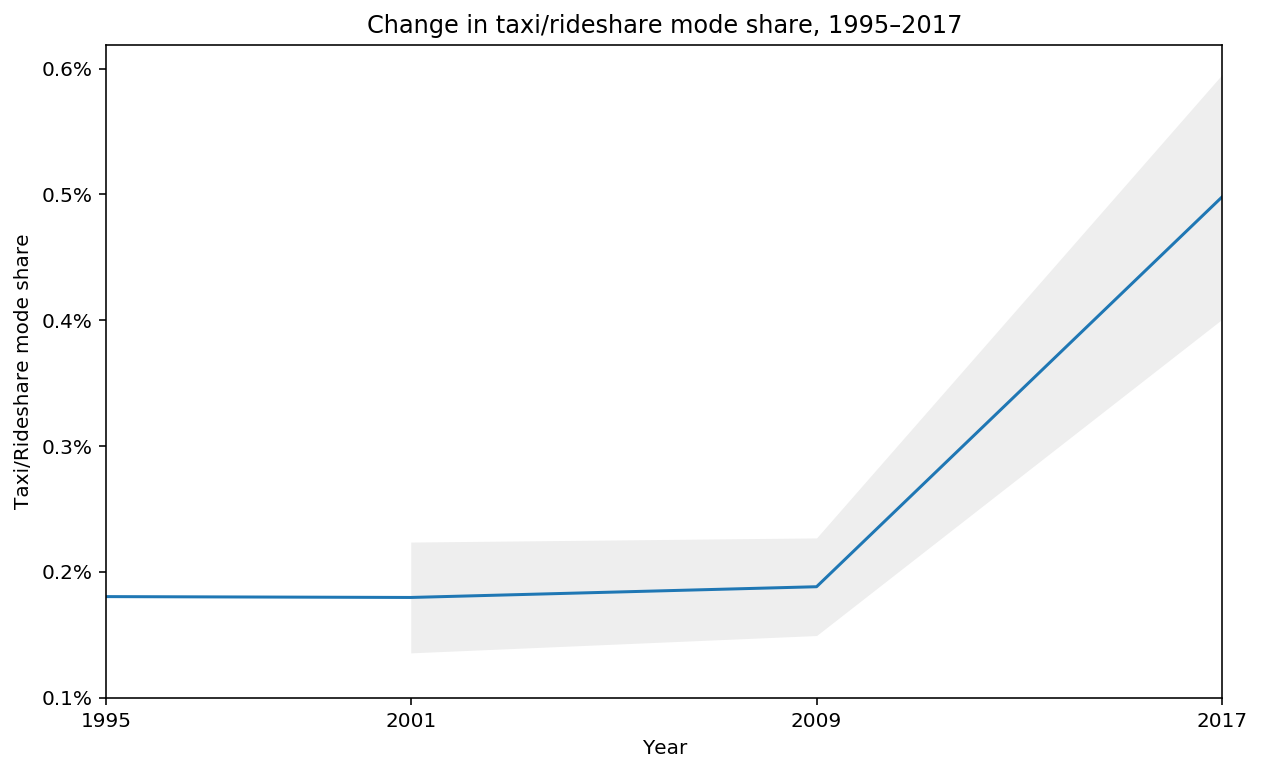

In [17]:
modeshare = pd.DataFrame(dict(proportion=np.zeros(4), se=np.zeros(4)), index=[1995, 2001, 2009, 2017])

# Use travel day weights so we don't undercount weekends
modeshare.loc[2017, 'proportion'] = np.sum(trips17[trips17.TRPTRANS.isin(TAXI_MODE[2017])][WEIGHTS[2017]]) / np.sum(trips17[WEIGHTS[2017]])
modeshare.loc[2017, 'se'] = estReplicateSE(
    lambda i: np.sum(trips17[trips17.TRPTRANS.isin(TAXI_MODE[2017])][f'{REP_WEIGHTS[2017]}{i}']) / np.sum(trips17[f'{REP_WEIGHTS[2017]}{i}']),
    modeshare.loc[2017, 'proportion'],
    year=2017
)

# 2009 travel day weights and person weights are linear functions of each other, so it doesn't matter which we use,
# except that day weights are not present for zero-trip-makers, so use person weights
# They did not oversample weekdays in 2009
modeshare.loc[2009, 'proportion'] = np.sum(trips09[trips09.TRPTRANS.isin(TAXI_MODE[2009])][WEIGHTS[2009]]) / np.sum(trips09[WEIGHTS[2009]])
modeshare.loc[2009, 'se'] = estReplicateSE(
    lambda i: np.sum(trips09[trips09.TRPTRANS.isin(TAXI_MODE[2009])][f'{REP_WEIGHTS[2009]}{i}']) / np.sum(trips09[f'{REP_WEIGHTS[2009]}{i}']),
    modeshare.loc[2009, 'proportion'],
    year=2009
)

modeshare.loc[2001, 'proportion'] = np.sum(trips01[trips01.TRPTRANS.isin(TAXI_MODE[2001])][WEIGHTS[2001]]) / np.sum(trips01[WEIGHTS[2001]])
modeshare.loc[2001, 'se'] = estReplicateSE(
    lambda i: np.sum(trips01[trips01.TRPTRANS.isin(TAXI_MODE[2001])][f'{REP_WEIGHTS[2001]}{i}']) / np.sum(trips01[f'{REP_WEIGHTS[2001]}{i}']),
    modeshare.loc[2001, 'proportion'],
    year=2001
)

modeshare.loc[1995, 'proportion'] = np.sum(trips95[trips95.TRPTRANS.isin(TAXI_MODE[1995])][WEIGHTS[1995]]) / np.sum(trips95[WEIGHTS[1995]])
modeshare.loc[1995, 'se'] = np.nan

plt.figure(figsize=(10,6))
plt.title('Change in taxi/rideshare mode share, 1995–2017')
plt.fill_between(
    modeshare.index.values[1:], 
    (modeshare.proportion + 1.96 * modeshare.se).iloc[1:] * 100,
    (modeshare.proportion - 1.96 * modeshare.se).iloc[1:] * 100,
    color='#eeeeee',
    lw=0
)
plt.plot(modeshare.index, modeshare.proportion * 100)
plt.xticks(modeshare.index)
plt.xlabel('Year')
plt.ylabel('Taxi/Rideshare mode share')
plt.xlim(1995, 2017)
plt.yticks(np.arange(0.1, 0.7, 0.1), [f'{t:.1f}%' for t in np.arange(0.1, 0.7, 0.1)])

#### Look at the percent of the population that used a for-hire vehicle on a particular day

We expect for-hire vehicles to be a marginal mode; most people who use them don't likely use them exclusively. Let's look at the percentage of people who took at least one for-hire vehicle trip on the travel day.

([<matplotlib.axis.YTick at 0x1b58537860>,
 <a list of 9 Text yticklabel objects>)

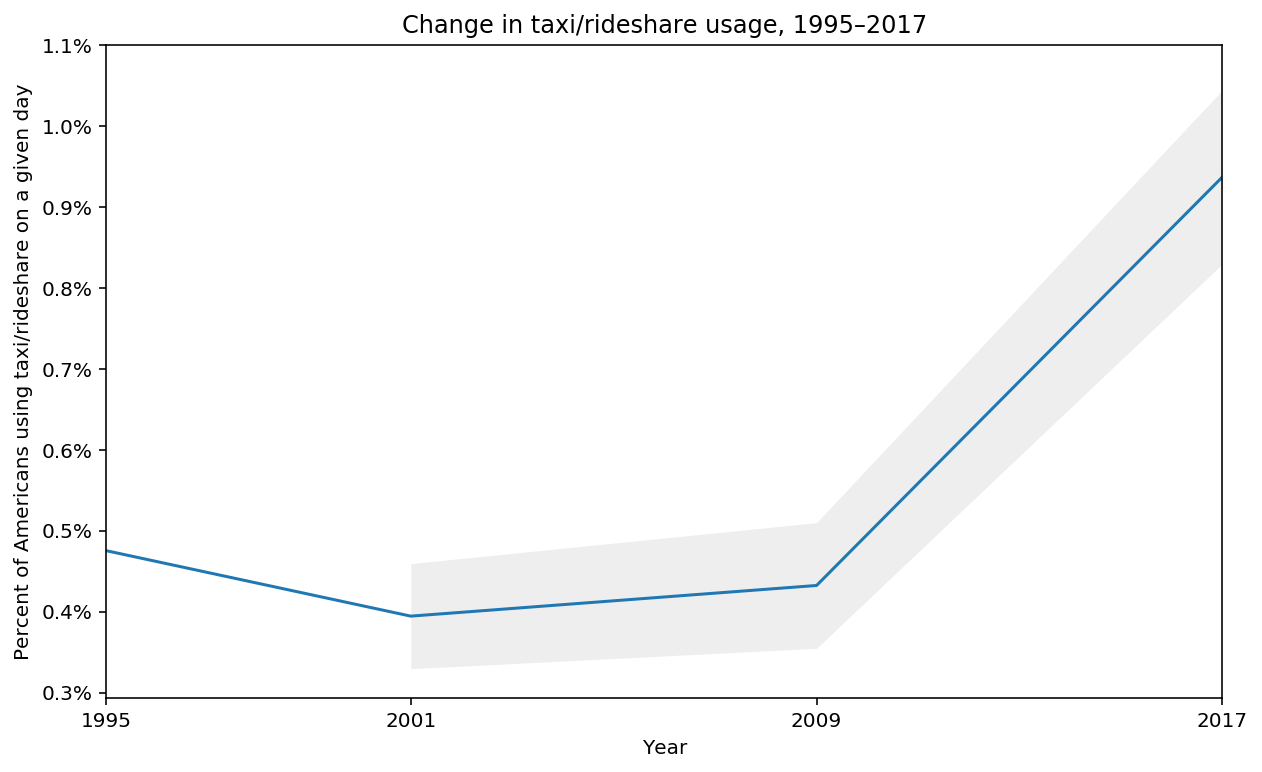

In [18]:
percent = pd.DataFrame(dict(proportion=np.zeros(4), se=np.zeros(4)), index=[1995, 2001, 2009, 2017])

# Use travel day weights so we don't undercount weekends
percent.loc[2017, 'proportion'] = np.sum(pers17[pers17.taxi][WEIGHTS[2017]]) / np.sum(pers17[WEIGHTS[2017]])
percent.loc[2017, 'se'] = estReplicateSE(
    lambda i: np.sum(pers17[pers17.taxi][f'{REP_WEIGHTS[2017]}{i}']) / np.sum(pers17[f'{REP_WEIGHTS[2017]}{i}']),
    percent.loc[2017, 'proportion'],
    year=2017
)

# 2009 travel day weights and person weights are linear functions of each other, so it doesn't matter which we use,
# except that day weights are not present for zero-trip-makers, so use person weights
# They did not oversample weekdays in 2009
percent.loc[2009, 'proportion'] = np.sum(pers09[pers09.taxi][WEIGHTS[2009]]) / np.sum(pers09[WEIGHTS[2009]])
percent.loc[2009, 'se'] = estReplicateSE(
    lambda i: np.sum(pers09[pers09.taxi][f'{REP_WEIGHTS[2009]}{i}']) / np.sum(pers09[f'{REP_WEIGHTS[2009]}{i}']),
    percent.loc[2009, 'proportion'],
    year=2009                           
)

percent.loc[2001, 'proportion'] = np.sum(pers01[pers01.taxi][WEIGHTS[2001]]) / np.sum(pers01[WEIGHTS[2001]])
percent.loc[2001, 'se'] = estReplicateSE(
    lambda i: np.sum(pers01[pers01.taxi][f'{REP_WEIGHTS[2001]}{i}']) / np.sum(pers01[f'{REP_WEIGHTS[2001]}{i}']),
    percent.loc[2001, 'proportion'],
    year=2001
)


percent.loc[1995, 'proportion'] = np.sum(pers95[pers95.taxi][WEIGHTS[1995]] / np.sum(pers95[WEIGHTS[1995]]))
percent.loc[1995, 'se'] = np.nan

plt.figure(figsize=(10,6))
plt.title('Change in taxi/rideshare usage, 1995–2017')
plt.fill_between(
    percent.index.values[1:], 
    (percent.proportion + 1.96 * percent.se).iloc[1:] * 100,
    (percent.proportion - 1.96 * percent.se).iloc[1:] * 100,
    color='#eeeeee',
    lw=0
)
plt.plot(percent.index, percent.proportion * 100)
plt.xticks(percent.index)
plt.xlabel('Year')
plt.ylabel('Percent of Americans using taxi/rideshare on a given day')
plt.xlim(1995, 2017)
plt.yticks(np.arange(0.3, 1.2, 0.1), [f'{t:.1f}%' for t in np.arange(0.3, 1.2, 0.1)])

### Combine the two figures

They show similar trends, and we don't need to waste (electronic) paper with two figures when one will do.

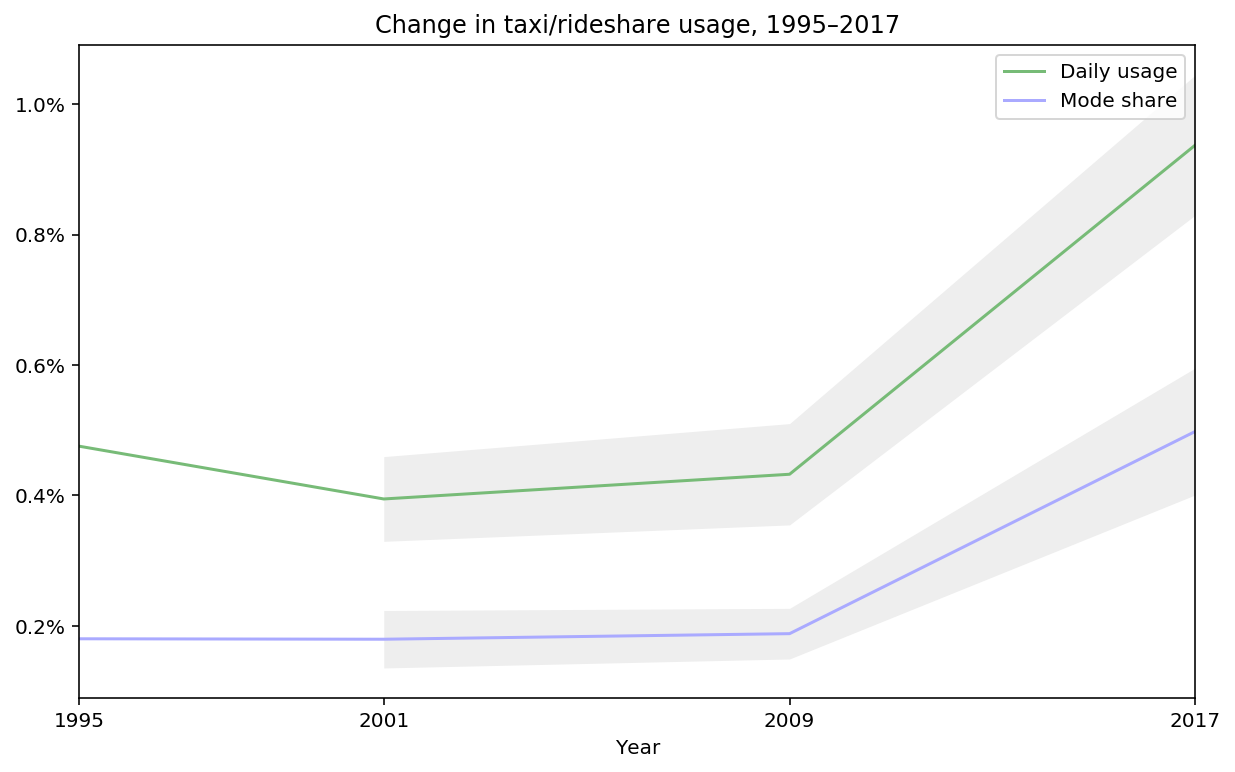

In [19]:
plt.figure(figsize=(10,6))
plt.title('Change in taxi/rideshare usage, 1995–2017')
plt.fill_between(
    percent.index.values[1:], 
    (percent.proportion + 1.96 * percent.se).iloc[1:] * 100,
    (percent.proportion - 1.96 * percent.se).iloc[1:] * 100,
    color='#eeeeee',
    lw=0
)
plt.plot(percent.index, percent.proportion * 100, color=TAXI_COLOR, label='Daily usage')
plt.xticks(percent.index)
plt.xlabel('Year')
plt.xlim(1995, 2017)
plt.yticks(np.arange(0.0, 1.2, 0.2), [f'{t:.1f}%' for t in np.arange(0.0, 1.2, 0.2)])

plt.fill_between(
    modeshare.index.values[1:], 
    (modeshare.proportion + 1.96 * modeshare.se).iloc[1:] * 100,
    (modeshare.proportion - 1.96 * modeshare.se).iloc[1:] * 100,
    color='#eeeeee',
    lw=0
)
plt.plot(modeshare.index, modeshare.proportion * 100, color=GENERAL_COLOR, label='Mode share')
plt.legend()
plt.savefig('../fig/growth_mode.pdf', bbox_inches='tight')


### Print out the results as tables

Because we want to quote a few precise results in the paper, we need to have the numbers.

In [20]:
modeshare['moe'] = modeshare.se * 1.96
(modeshare * 100).round(2)

,proportion,se,moe
1995,0.18,NaN,NaN
2001,0.18,0.02,0.04
2009,0.19,0.02,0.04
2017,0.50,0.05,0.10


In [21]:
percent['moe'] = percent.se * 1.96
(percent * 100).round(2)

,proportion,se,moe
1995,0.48,NaN,NaN
2001,0.39,0.03,0.06
2009,0.43,0.04,0.08
2017,0.94,0.05,0.11


## Modal exclusivity/multimodality

As mentioned above, we don't expect people who do use for-hire vehicles to use them a lot. This computes the exclusivity of a whole bunch of different modes to compare them. Unsurprisingly, driving is quite exclusive. Most drivers make all of their trips by driving. The same is not true of for-hire vehicles.

This is averaged over persons, I don't think we want heavier trip makers to weigh in more.

In [75]:
exclusivityTable = pd.DataFrame(
    columns=['est', 'se'],
    index=['For-hire vehicle', 'Auto', 'Transit', 'Walking', 'Biking', 'Active travel', 'Transit and walking'])

if True: # This takes a really long time to run, skip by default
    for mode, modeCodes in [
        ('For-hire vehicle', TAXI_MODE[2017]),
        ('Auto', [3, 4, 5, 6]),
        #('Transit', [11, 15, 16]),
        #('Walking', [1]),
        #('Biking', [2]),
        #('Biking and walking', [1, 2]),
        #('Transit and walking', [1, 11, 15, 16])
    ]:
        # weight is constant for each person (trips do not have different weights), so no weights needed here
        persProp = trips17.groupby(['HOUSEID', 'PERSONID'], as_index=False).TRPTRANS\
            .agg(lambda x: np.sum(x.isin(modeCodes)) / np.sum(x >= 0) if np.sum(x >= 0) > 0 else 0)
        persProp = persProp[persProp.TRPTRANS > 0]
        persProp = persProp.merge(pers17, on=['HOUSEID', 'PERSONID'], how='left', validate='1:1')
        # Now take a weighted average
        propModeForModeUsers = np.average(persProp.TRPTRANS, weights=persProp.WTPERFIN / 1000) # avoid overflow
        propModeForModeUsers_se = estReplicateSE(
            lambda i: np.average(persProp.TRPTRANS, weights=persProp[f'WTPERFIN{i}'] / 1000),
            propModeForModeUsers,
            2017
        )

        exclusivityTable.loc[mode, 'est'] = propModeForModeUsers
        exclusivityTable.loc[mode, 'se'] = propModeForModeUsers_se
        
exclusivityTable['moe'] = exclusivityTable.se * 1.96
exclusivityTable * 100

,est,se,moe
For-hire vehicle,44.9958,1.44303,2.82833
Auto,92.6902,0.126449,0.247841
Transit,NaN,NaN,NaN
Walking,NaN,NaN,NaN
Biking,NaN,NaN,NaN
Active travel,NaN,NaN,NaN
Transit and walking,NaN,NaN,NaN


## Where do for-hire vehicle trips start and end

Is using the home location built environment characteristics appropriate?

In [23]:
taxiTrips = trips17[trips17.TRPTRANS.isin(TAXI_MODE[2017])]
# WHYTO/WHYFROM 1, 2 are home and work from home
homeTaxiTrips = taxiTrips[taxiTrips.WHYTO.isin([1, 2]) | taxiTrips.WHYFROM.isin([1, 2])]
print('FHV trips beginning/ending at home: ', computeValueAndSE(homeTaxiTrips, taxiTrips, 2017))

FHV trips beginning/ending at home:  $63.74\% \pm 10.42$


## Geographic trends

Ridehailing has expanded the geographic reach of for-hire vehicles beyond their former bastions in a few large cities (sometime, ask me about my experience getting a cab in Macon, Georgia before ridehailing existed). Quantify these trends.

In [24]:
# Helpfully, the NHTS has used almost the same MSA size codes since 1995, with the only exception being that some
# years have "Not in MSA" as 6, and some have it as 94.

for dta in [pers95, pers01, pers09, pers17, trips95, trips01, trips09, trips17]:
        dta['msaSize'] = dta.MSASIZE.replace({
            -9: np.nan, # There are 2 NANs in 2009. I don't know how that happened but it did.
            94: 'Not in MSA', # 1995
            6: 'Not in MSA', # 2001-2017
            1: 'Less than 250,000',
            2: '250,000 to 499,999',
            3: '500,000 to 999,999',
            4: '1,000,000 to 2,999,999',
            5: 'More than 3 million'
        }).astype('category').cat.reorder_categories([
            'Not in MSA',
            'Less than 250,000',
            '250,000 to 499,999',
            '500,000 to 999,999',
            '1,000,000 to 2,999,999',
            'More than 3 million'
        ])

pass # supress printing

In [25]:
# Define a function that plots daily usage among subsets of the data
def plotBySubsets (subsets95, subsets01, subsets09, subsets17, colors=None, lineStyles=None, filename=None,
                   title=None, outlines=[], ax=None):
    columns = None
    # Create a data frame to store the usage percentages for each group in each year
    # First, figure out which years we're talking about
    years = []
    if subsets95 is not None:
        years.append(1995)
    if subsets01 is not None:
        years.append(2001)
    if subsets09 is not None:
        years.append(2009)
    if subsets17 is not None:
        years.append(2017)
    
    usageProp = pd.DataFrame(columns=columns, index=years)

    # . . . and one to store the standard errors
    usageSE = pd.DataFrame(columns=columns, index=years)

    for yr, dta, subsets in [
        (1995, pers95, subsets95),
        (2001, pers01, subsets01),
        (2009, pers09, subsets09),
        (2017, pers17, subsets17)
    ]:
        if subsets is None:
            continue # not plotting this year
            
        if columns is None:
            columns = list(subsets.keys())
        
        for subsetLabel in columns:
            usageProp.loc[yr, subsetLabel] =\
                np.sum(dta.loc[(subsets[subsetLabel]) & dta.taxi, WEIGHTS[yr]]) /\
                    np.sum(dta.loc[(subsets[subsetLabel]), WEIGHTS[yr]])

            if yr != 1995:
                usageSE.loc[yr, subsetLabel] = estReplicateSE(
                    lambda i: np.sum(dta.loc[(subsets[subsetLabel]) & dta.taxi, f'{REP_WEIGHTS[yr]}{i}']) /\
                        np.sum(dta.loc[(subsets[subsetLabel]), f'{REP_WEIGHTS[yr]}{i}']),
                    usageProp.loc[yr, subsetLabel],
                    yr
                )
            else:
                # no repl weights for 1995
                usageSE.loc[yr, subsetLabel] = np.nan

    usageProp *= 100
    usageSE *= 100
    usageMOE = usageSE * 1.96
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 10))
    
    for subsetLabel in columns:
        est = usageProp.loc[:,subsetLabel].astype('float64')
        moe = usageMOE.loc[:,subsetLabel].astype('float64')
        lineStyle = lineStyles[subsetLabel] if lineStyles is not None else '-'
        generatedColorVals = {
            'r': ((pers17[subsets17[subsetLabel]].R_AGE.iloc[0] * 11) % 255) / 255,
            'g': ((pers17[subsets17[subsetLabel]].R_AGE.iloc[1] * 11) % 255) / 255,
            'b': ((pers17[subsets17[subsetLabel]].R_AGE.iloc[2] * 11) % 255) / 255
        }
        generatedColor = 'rgb({r},{g},{b})'.format(**generatedColorVals)
        color = colors[subsetLabel] if colors is not None else generatedColor
        if subsetLabel in outlines:
            plt.plot(usageProp.index, est - moe, color=color, ls='--', alpha=0.5, lw=1)
            plt.plot(usageProp.index, est + moe, color=color, ls='--', alpha=0.5, lw=1)
        else:
            plt.fill_between(usageProp.index, est - moe, est + moe, color=color, alpha=0.15, lw=0)
        plt.plot(usageProp.index, est, color=color, label=subsetLabel, ls=lineStyle)
        
        # labels on right
        wrappedLabel = textwrap.fill(subsetLabel, break_long_words=False, width=30)
        nLinesInLabel = wrappedLabel.count('\n') + 1
        plt.text(max(years) + 0.1, est.iloc[-1] - nLinesInLabel * 0.04, wrappedLabel)

    if title is not None:
        plt.title(title)
    plt.xlim((min(years), max(years)))
    plt.xticks(years)
    plt.ylabel('Percentage of people taking a\nfor-hire vehicle trip on any given day')

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:.2f}%'))
        
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')

## Income trends

We should deal with inflation as much as possible. The first cell computes what dollar value in a given corresponds to the 2016 25k, 50k, and 100k cutpoints we use in the model.

In [26]:
cpi = pd.read_excel('../data/cpi.xlsx', skiprows=11).set_index('Year')

def getCpiInflationFactor (fromYear, toYear):
    fromCpi = cpi.loc[fromYear, 'Annual']
    toCpi = cpi.loc[toYear, 'Annual']
    return toCpi / fromCpi

def roundToNearest (sourceArray, targetArray):
    # https://stackoverflow.com/questions/2566412
    sourceArray = np.asarray(sourceArray)
    targetArray = np.asarray(targetArray)
    return np.vectorize(lambda x: targetArray[np.abs(x - targetArray).argmin()])(sourceArray)

# These breaks are used 1995-2009
breaks = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 100]) * 1000

for year in [1995, 2001, 2009]:
    # - 1 because it's the previous year's income
    factor = getCpiInflationFactor(year - 1, 2016)
    targetCuts = np.array([25000, 50000, 100000]) / factor
    rounded = roundToNearest(targetCuts, breaks)
    print(f'For the {year} NHTS, target categories to match 2017 are {targetCuts.round(0)}')
    print(f'  Rounded to breaks: {rounded}')
    print(f'  Errors: {(rounded - targetCuts).round(0)}')

For the 1995 NHTS, target categories to match 2017 are [15437. 30874. 61748.]
  Rounded to breaks: [15000 30000 60000]
  Errors: [ -437.  -874. -1748.]
For the 2001 NHTS, target categories to match 2017 are [17937. 35874. 71748.]
  Rounded to breaks: [20000 35000 70000]
  Errors: [ 2063.  -874. -1748.]
For the 2009 NHTS, target categories to match 2017 are [22427. 44853. 89707.]
  Rounded to breaks: [20000 45000 80000]
  Errors: [-2427.   147. -9707.]


In [27]:
pers95['incomeCategory'] = pers95.HHFAMINC.replace({
    1: 'Less than $15,000',
    2: 'Less than $15,000',
    3: 'Less than $15,000',
    4: '$15,000--$29,999',
    5: '$15,000--$29,999',
    6: '$15,000--$29,999',
    7: '$30,000--$59,999',
    8: '$30,000--$59,999',
    9: '$30,000--$59,999',
    10: '$30,000--$59,999',
    11: '$30,000--$59,999',
    12: '$30,000--$59,999',
    13: '$60,000 or more',
    14: '$60,000 or more',
    15: '$60,000 or more',
    16: '$60,000 or more',
    17: '$60,000 or more',
    18: '$60,000 or more',
    98: np.nan,
    99: np.nan
}).astype('category').cat.reorder_categories([
    'Less than $15,000',
    '$15,000--$29,999',
    '$30,000--$59,999',
    '$60,000 or more'
])

pers01['incomeCategory'] = pers01.HHFAMINC.replace({
    -1: np.nan,
    -7: np.nan,
    -8: np.nan,
    -9: np.nan,
    1: 'Less than $20,000',
    2: 'Less than $20,000',
    3: 'Less than $20,000',
    4: 'Less than $20,000',
    5: '$20,000--$34,999',
    6: '$20,000--$34,999',
    7: '$20,000--$34,999',
    8: '$35,000--$69,999',
    9: '$35,000--$69,999',
    10: '$35,000--$69,999',
    11: '$35,000--$69,999',
    12: '$35,000--$69,999',
    13: '$35,000--$69,999',
    14: '$35,000--$69,999',
    15: '$70,000 or more',
    16: '$70,000 or more',
    17: '$70,000 or more',
    18: '$70,000 or more'
}).astype('category').cat.reorder_categories([
    'Less than $20,000',
    '$20,000--$34,999',
    '$35,000--$69,999',
    '$70,000 or more'
])

pers09['incomeCategory'] = pers09.HHFAMINC.replace({
    -7: np.nan,
    -8: np.nan,
    -9: np.nan,
    1: 'Less than $20,000',
    2: 'Less than $20,000',
    3: 'Less than $20,000',
    4: 'Less than $20,000',
    5: '$20,000--$44,999',
    6: '$20,000--$44,999',
    7: '$20,000--$44,999',
    8: '$20,000--$44,999',
    9: '$20,000--$44,999',
    10: '$45,000--$79,999',
    11: '$45,000--$79,999',
    12: '$45,000--$79,999',
    13: '$45,000--$79,999',
    14: '$45,000--$79,999',
    15: '$45,000--$79,999',
    16: '$45,000--$79,999',
    17: '$80,000 or more',
    18: '$80,000 or more',
}).astype('category').cat.reorder_categories([
    'Less than $20,000',
    '$20,000--$44,999',
    '$45,000--$79,999',
    '$80,000 or more'
])

pers17['incomeCategory'] = pers17.HHFAMINC\
    .replace({
    -7: np.nan,
    -8: np.nan,
    -9: np.nan,
    1: 'Less than \$25,000',
    2: 'Less than \$25,000',
    3: 'Less than \$25,000',
    4: '\$25,000--\$49,999',
    5: '\$25,000--\$49,999',
    6: '\$50,000--\$99,999',
    7: '\$50,000--\$99,999',
    8: '\$100,000 or more',
    9: '\$100,000 or more',
    10: '\$100,000 or more',
    11: '\$100,000 or more'
})\
    .astype('category')\
    .cat\
    .reorder_categories([
        'Less than \$25,000',
        '\$25,000--\$49,999',
        '\$50,000--\$99,999',
        '\$100,000 or more'
    ])
    
    
trips17['incomeCategory'] = trips17.HHFAMINC\
    .replace({
    -7: np.nan,
    -8: np.nan,
    -9: np.nan,
    1: 'Less than \$25,000',
    2: 'Less than \$25,000',
    3: 'Less than \$25,000',
    4: '\$25,000--\$49,999',
    5: '\$25,000--\$49,999',
    6: '\$50,000--\$99,999',
    7: '\$50,000--\$99,999',
    8: '\$100,000 or more',
    9: '\$100,000 or more',
    10: '\$100,000 or more',
    11: '\$100,000 or more'
})\
    .astype('category')\
    .cat\
    .reorder_categories([
        'Less than \$25,000',
        '\$25,000--\$49,999',
        '\$50,000--\$99,999',
        '\$100,000 or more'
    ])

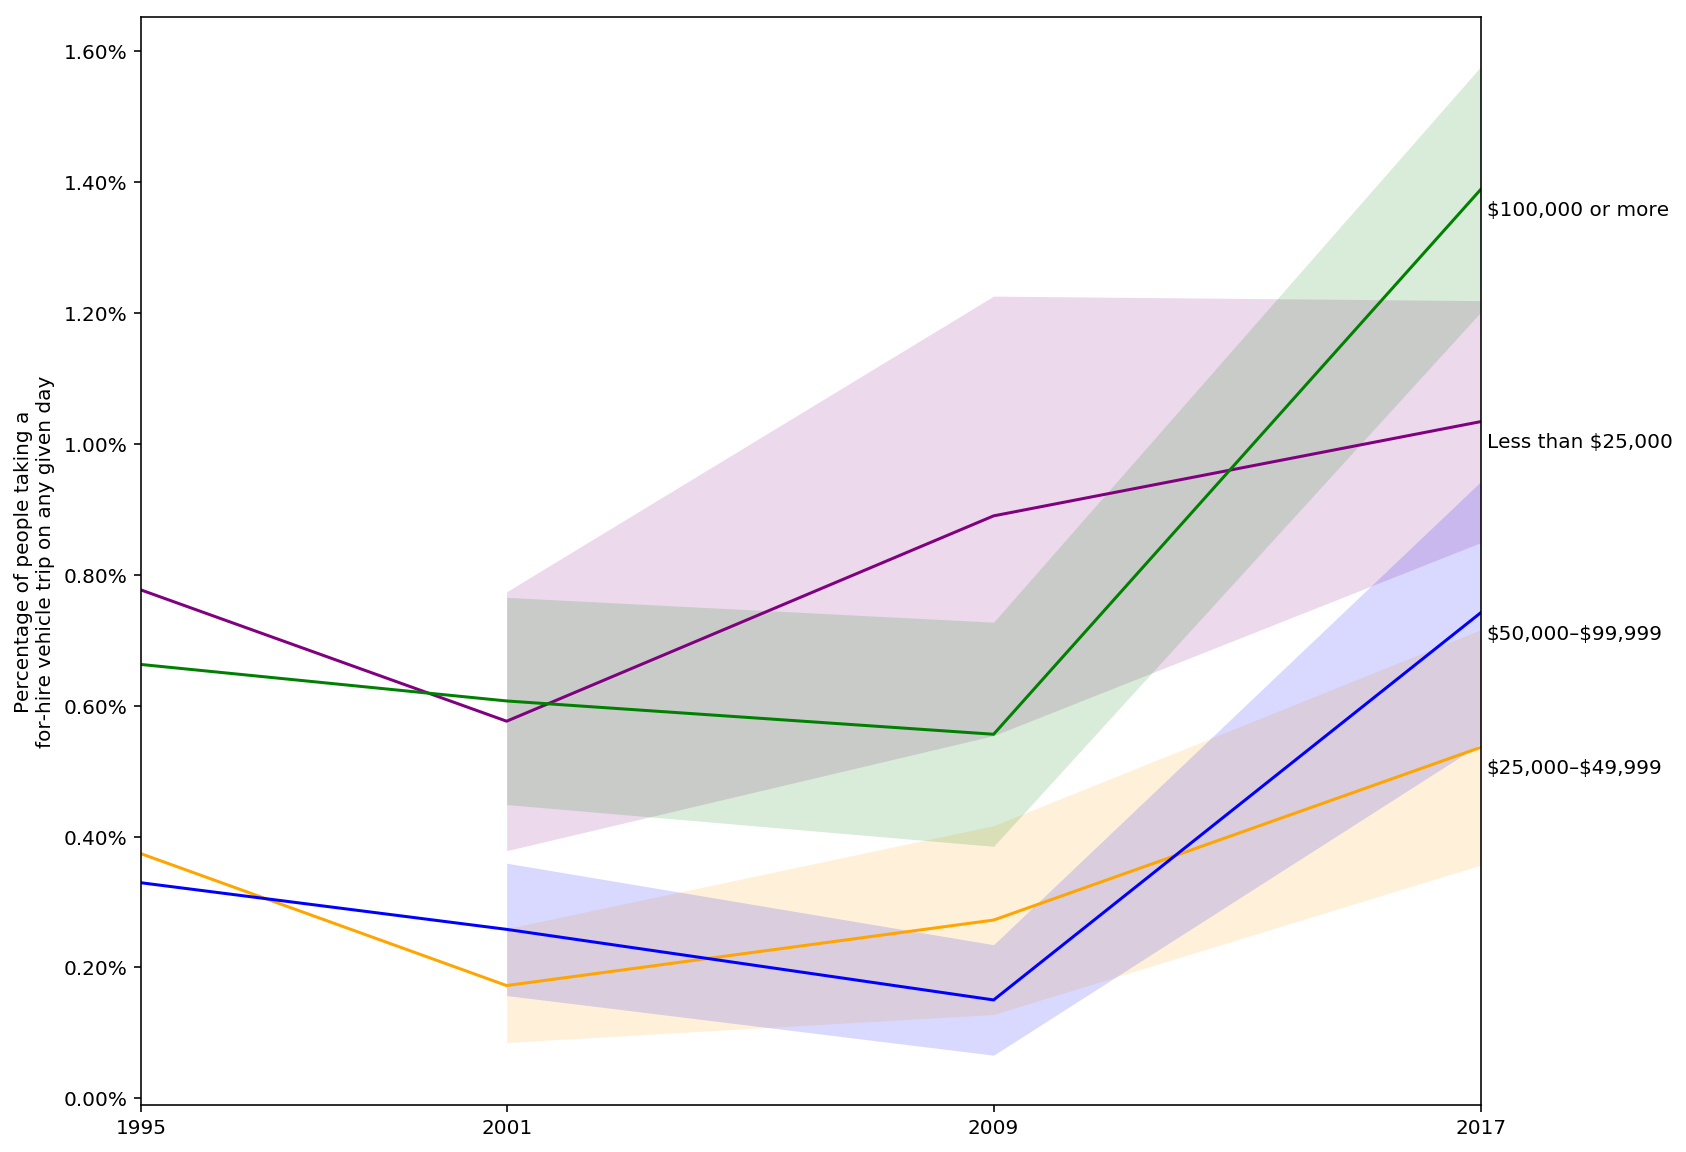

In [28]:
plotBySubsets(
    # not all years used the same income labels, due to CPI adjustment, but they use the same categories
    # in the same orders
    *[{
        'Less than \$25,000': dta.incomeCategory == dta.incomeCategory.cat.categories[0],
        '\$25,000–\$49,999': dta.incomeCategory == dta.incomeCategory.cat.categories[1],
        '\$50,000–\$99,999': dta.incomeCategory == dta.incomeCategory.cat.categories[2],
        '\$100,000 or more': dta.incomeCategory == dta.incomeCategory.cat.categories[3]
    } for dta in [pers95, pers01, pers09, pers17]],
    colors={
        'Less than \$25,000': 'purple',
        '\$25,000–\$49,999': 'orange',
        '\$50,000–\$99,999': 'blue',
        '\$100,000 or more': 'green'
    },
    filename='../fig/income_trends.pdf'
)

## Show the growth since 2009 in different geographies

Divide the 2017 value by the 2009 in several different geographies.

It's not entirely clear how to compute the confidence intervals on these ratios. Since the numerator and the denominator come from different surveys, they have different replicate weights. Furthermore, they have a different _number_ of replicate weights, and the scale factor to estimate the standard errors differs. To address this, I take two approaches. Both involve first estimating the standard error of the number of trips taken in each year using standard replicate weight variance estimation methods. To get the standard error of the ratio of these two variables, I take two approaches. This first is a Monte Carlo approach: I treat the two estimates as coming from independent random normal distributions, draw 1 million samples from each distribution, subtract them, and take percentiles. This yields the CIs shown in the first horizontal bar chart below (the histogram shows the distribution of the differences).

The second approach is analytical, using Taylor series, and uses the formula described in Wolter (2007), p. 241. The formula for the variance of a ratio given in that source is

$ Var(\frac{\hat x}{\hat y}) = (\frac{\hat x}{\hat y})^2 [ \frac{Var(\hat y)}{\hat y^2} + \frac{Var(\hat x)}{\hat x^2} - 2\frac{Cov(\hat x, \hat y)}{\hat x \hat y}] $

Given that the surveys are independent, I assume $Cov(\hat x, \hat y) = 0$ and the third term drops out. This approach yields somewhat longer confidence intervals than the Monte Carlo approach, perhaps due to this assumption (even with 1 million random samples, it is unlikely the covariance between two random variables is exactly 0).

In [29]:
# Compute the subset that is in each 
subsets17 = pd.DataFrame({
    'New York metro': trips17.HH_CBSA == '35620',
    'Eastern metros': trips17.HH_CBSA.isin(['35620', '16980', '14460', '47900', '37980']),
    'MSAs > 3 million': trips17.msaSize == 'More than 3 million',
    'MSAs 1–3 million': trips17.msaSize == '1,000,000 to 2,999,999',
    'MSAs < 1 million/non-MSA': ~trips17.msaSize.isin(['1,000,000 to 2,999,999', 'More than 3 million']),
    'USA': np.repeat(True, len(trips17))
})

subsets09 = pd.DataFrame({
    'New York metro': trips09.HH_CBSA == '35620',
    'Eastern metros': trips09.HH_CBSA.isin(['35620', '16980', '14460', '47900', '37980']),
    'MSAs > 3 million': trips09.msaSize == 'More than 3 million',
    'MSAs 1–3 million': trips09.msaSize == '1,000,000 to 2,999,999',
    'MSAs < 1 million/non-MSA': ~trips09.msaSize.isin(['1,000,000 to 2,999,999', 'More than 3 million']),
    'USA': np.repeat(True, len(trips09))
})

result17 = subsets17.apply(lambda x: np.sum(trips17[x & trips17.TRPTRANS.isin(TAXI_MODE[2017])][WEIGHTS[2017]]))
result09 = subsets09.apply(lambda x: np.sum(trips09[x & trips09.TRPTRANS.isin(TAXI_MODE[2009])][WEIGHTS[2009]]))
result = result17 / result09

se17 = subsets17.apply(lambda x: estReplicateSE(
    lambda i: np.sum(trips17[x & trips17.TRPTRANS.isin(TAXI_MODE[2017])][f'{REP_WEIGHTS[2017]}{i}']),
    result17.loc[x.name],
    2017))

se09 = subsets09.apply(lambda x: estReplicateSE(
    lambda i: np.sum(trips09[x & trips09.TRPTRANS.isin(TAXI_MODE[2009])][f'{REP_WEIGHTS[2009]}{i}']),
    result09.loc[x.name],
    2009))

# Not clear how to compute the variance directly across two different years, so compute it via sampling
N = 1000000
ci = { idx: np.percentile(
                      scipy.stats.norm.rvs(result17.loc[idx], se17.loc[idx], size=N) /\
                      scipy.stats.norm.rvs(result09.loc[idx], se09.loc[idx], size=N),
                      [2.5, 97.5]
    ) for idx in result.index }

# display results
pd.DataFrame(dict(result17=result17, se17=se17, result09=result09, se09=se09))

,result09,result17,se09,se17
Eastern metros,1.100796e+06,2.027644e+06,140779.077418,356264.531562
MSAs 1–3 million,1.446955e+05,8.852101e+05,46262.842774,243766.262582
MSAs < 1 million/non-MSA,3.350074e+05,8.911101e+05,109634.010311,140784.887692
MSAs > 3 million,1.540907e+06,3.289990e+06,196851.706568,363658.956118
New York metro,7.124703e+05,1.194649e+06,102019.355423,366916.613305
USA,2.020610e+06,5.066310e+06,213125.477920,526417.908923


(array([ 10206.,  24555.,  48828.,  76010.,  96598., 106782., 105060.,
         94993.,  81690.,  67037.,  54185.,  43242.,  33998.,  26815.,
         21393.,  16769.,  13511.,  10842.,   8862.,   7043.,   5944.,
          4860.,   3986.,   3524.,   2874.,   2514.,   2111.,   1882.,
          1642.,   1377.,   1234.,   1078.,   1026.,    839.,    770.,
           706.,    654.,    584.,    503.,    436.,    423.,    396.,
           347.,    306.,    327.,    256.,    276.,    262.,    233.,
           211.]),
 array([ 1.50131946,  2.13548609,  2.76965273,  3.40381936,  4.037986  ,
         4.67215264,  5.30631927,  5.94048591,  6.57465254,  7.20881918,
         7.84298582,  8.47715245,  9.11131909,  9.74548572, 10.37965236,
        11.013819  , 11.64798563, 12.28215227, 12.9163189 , 13.55048554,
        14.18465218, 14.81881881, 15.45298545, 16.08715208, 16.72131872,
        17.35548536, 17.98965199, 18.62381863, 19.25798526, 19.8921519 ,
        20.52631854, 21.16048517, 21.79465181,

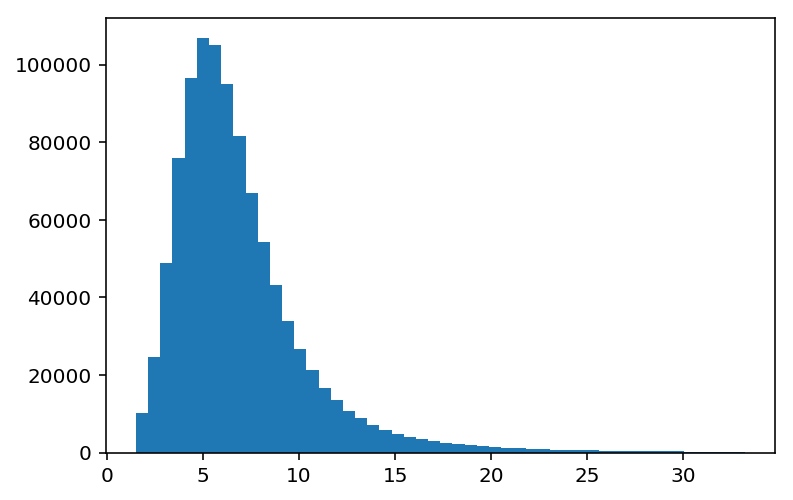

In [30]:
idx = 'MSAs 1–3 million'
samples = scipy.stats.norm.rvs(result17.loc[idx], se17.loc[idx], size=N) /\
                      scipy.stats.norm.rvs(result09.loc[idx], se09.loc[idx], size=N)
pct = np.percentile(samples, [0.5, 99.5])
samples = samples[(samples > pct[0]) & (samples < pct[1])]
plt.hist(samples, bins=50)

In [31]:
(result17 + 1.96 * se17) / (result09 - 1.96 * se09)

Eastern metros               3.304673
MSAs 1–3 million            25.231084
MSAs < 1 million/non-MSA     9.715307
MSAs > 3 million             3.465360
New York metro               3.734165
USA                          3.804447
dtype: float64

In [32]:
ci

{'Eastern metros': array([1.14612992, 2.78363094]),
 'MSAs 1–3 million': array([ 2.44395553, 17.40284648]),
 'MSAs < 1 million/non-MSA': array([1.4198981 , 7.49851253]),
 'MSAs > 3 million': array([1.5346885 , 3.01859916]),
 'New York metro': array([0.65141578, 2.99181576]),
 'USA': array([1.86750868, 3.3702344 ])}

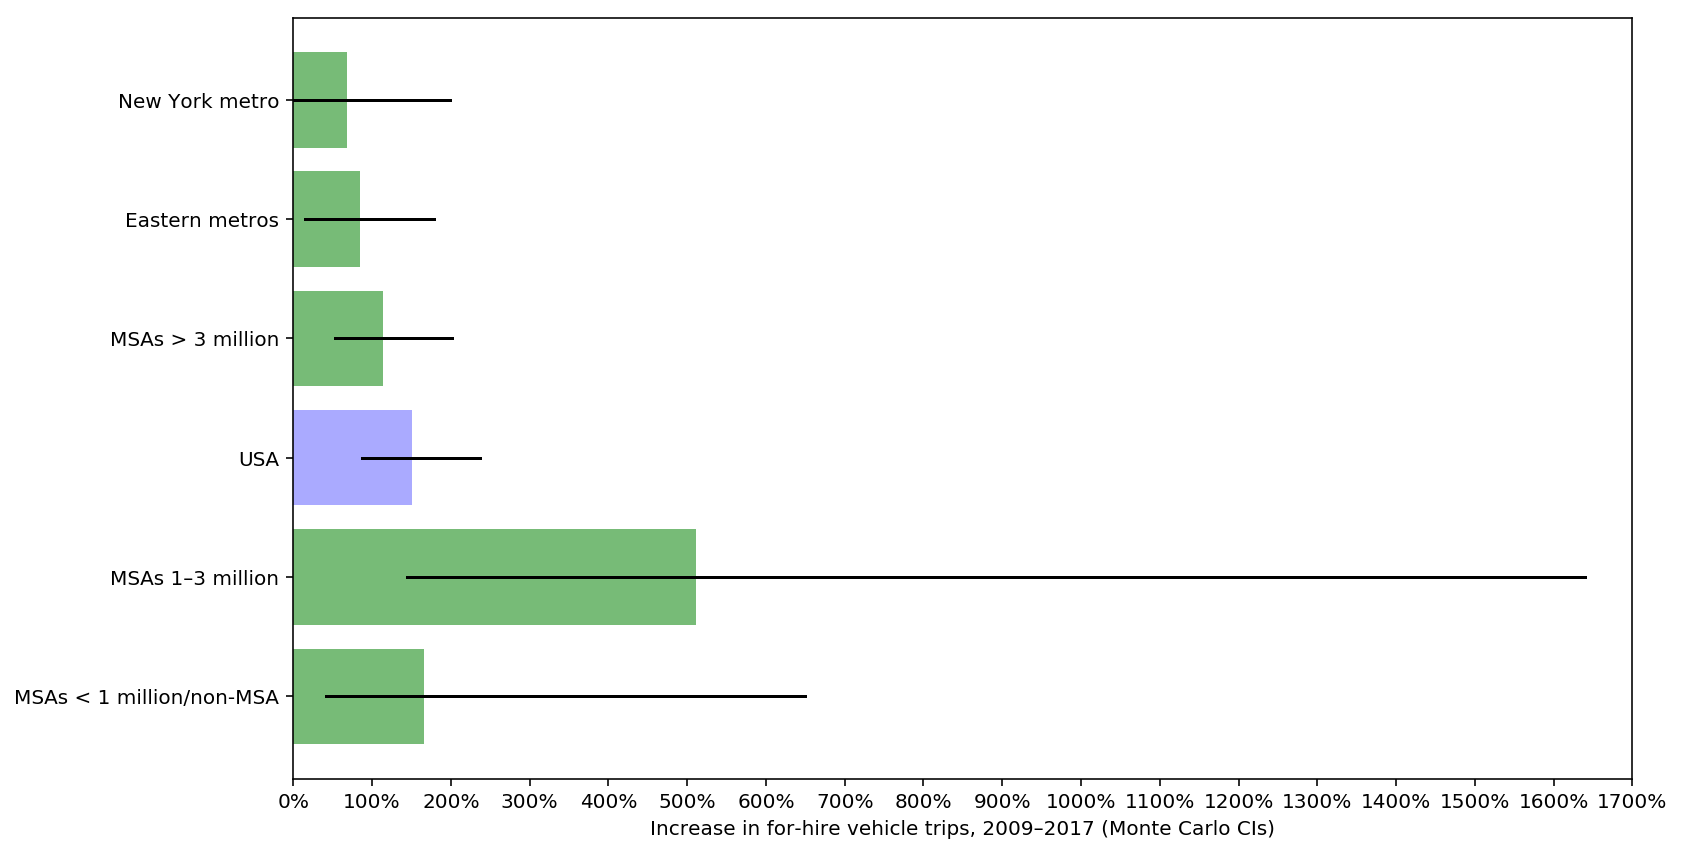

In [33]:
plt.figure(figsize=(12, 7))
order = ['New York metro', 'Eastern metros', 'MSAs > 3 million', 'USA',
       'MSAs 1–3 million', 'MSAs < 1 million/non-MSA']
plt.barh(-np.arange(len(order)), result.loc[order], color=[TAXI_COLOR, TAXI_COLOR, TAXI_COLOR, GENERAL_COLOR, TAXI_COLOR, TAXI_COLOR])
plt.yticks(-np.arange(len(order)), order)
plt.xlim(1, 18)
plt.xlabel('Increase in for-hire vehicle trips, 2009–2017 (Monte Carlo CIs)')
plt.xticks(np.arange(1, 19), [f'{x}%' for x in np.arange(0, 18) * 100])

for offset, label in zip(-np.arange(len(order)), order):
    plt.plot(ci[label], [offset, offset], '-', color='black')

#### Try estimating variance analytically

See Wolter (2007), p. 240.

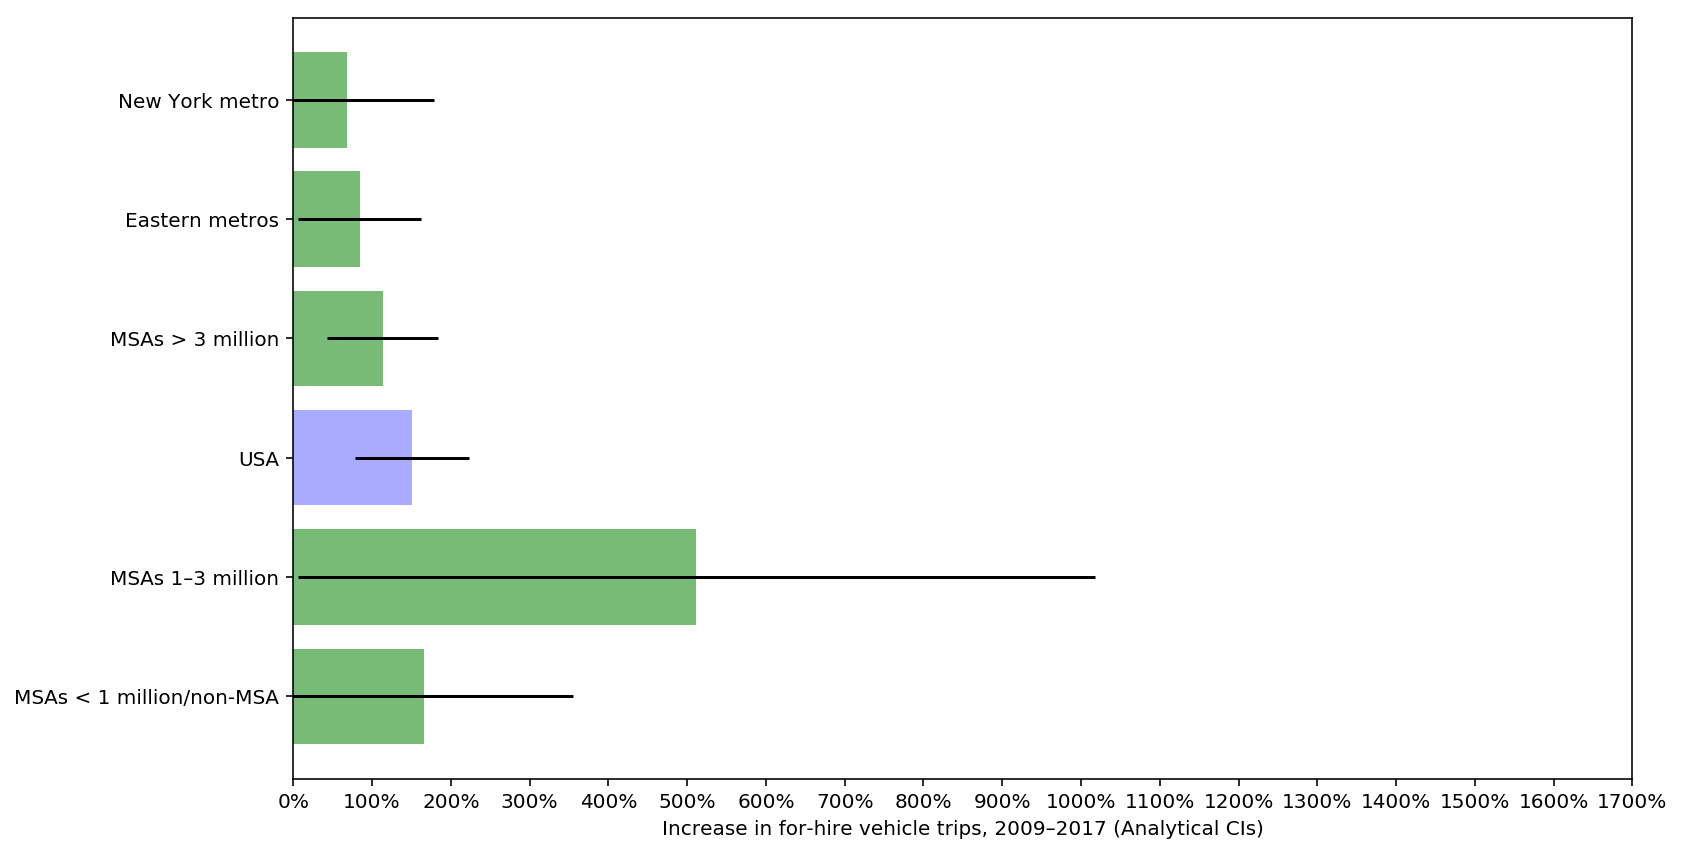

In [34]:
varEst = result ** 2 * (se17 ** 2 / result17 ** 2 + se09 ** 2 / result09 ** 2) 
seEst = np.sqrt(varEst)

plt.figure(figsize=(12, 7))
order = ['New York metro', 'Eastern metros', 'MSAs > 3 million', 'USA',
       'MSAs 1–3 million', 'MSAs < 1 million/non-MSA']
plt.barh(-np.arange(len(order)), result.loc[order], xerr=seEst.loc[order] * 1.96, color=[TAXI_COLOR, TAXI_COLOR, TAXI_COLOR, GENERAL_COLOR, TAXI_COLOR, TAXI_COLOR])
plt.yticks(-np.arange(len(order)), order)
plt.xlim(1, 18)
plt.xlabel('Increase in for-hire vehicle trips, 2009–2017 (Analytical CIs)')
plt.xticks(np.arange(1, 19), [f'{x}%' for x in np.arange(0, 18) * 100])
pass

### Look instead at proportions in different parts of the country

Since we're not dividing multiple surveys by each other, there's not as much error.

In [35]:
less1m = [
    'Not in MSA',
    'Less than 250,000',
    '250,000 to 499,999',
    '500,000 to 999,999'
]
            
proportionUsersMSA1m =\
    pd.DataFrame(dict(est=np.zeros(4), se=np.zeros(4)), index=[1995, 2001, 2009, 2017])
    
for year, dta in ((2017, pers17), (2009, pers09), (2001, pers01), (1995, pers95)):
    proportionUsersMSA1m.loc[year, 'est'] =\
        np.sum(dta.loc[dta.taxi & (dta.msaSize.isin(less1m)), WEIGHTS[year]]) /\
        np.sum(dta.loc[dta.taxi, WEIGHTS[year]])
    proportionUsersMSA1m.loc[year, 'se'] = np.nan if year == 1995 else estReplicateSE(
        lambda i: np.sum(dta.loc[dta.taxi & (dta.msaSize.isin(less1m)), f'{REP_WEIGHTS[year]}{i}']) /\
            np.sum(dta.loc[dta.taxi, f'{REP_WEIGHTS[year]}{i}']),
        proportionUsersMSA1m.loc[year, 'est'],
        year=year
    )

In [36]:
NYC = {
    2017: ('HH_CBSA', '35620'),
    2009: ('HH_CBSA', '35620'),
    2001: ('HHC_MSA', '5602'),
    1995: ('HHCMSA', 5602)
}

proportionUsersNYC =\
    pd.DataFrame(dict(est=np.zeros(4), se=np.zeros(4)), index=[1995, 2001, 2009, 2017])
    
for year, dta in ((2017, pers17), (2009, pers09), (2001, pers01), (1995, pers95)):
    cbsaCol, cbsa = NYC[year]
    proportionUsersNYC.loc[year, 'est'] =\
        np.sum(dta.loc[dta.taxi & (dta[cbsaCol] == cbsa), WEIGHTS[year]]) /\
        np.sum(dta.loc[dta.taxi, WEIGHTS[year]])
    proportionUsersNYC.loc[year, 'se'] = np.nan if year == 1995 else estReplicateSE(
        lambda i: np.sum(dta.loc[dta.taxi & (dta[cbsaCol] == cbsa), f'{REP_WEIGHTS[year]}{i}']) /\
            np.sum(dta.loc[dta.taxi, f'{REP_WEIGHTS[year]}{i}']),
        proportionUsersNYC.loc[year, 'est'],
        year=year
    )

In [37]:
# Boston, Chicago, DC, Philly
# Should we call Chicago a northeastern city?
NE = {
    2017: ('HH_CBSA', ['16980', '14460', '47900', '37980']),
    2009: ('HH_CBSA', ['16980', '14460', '47900', '37980']),
    2001: ('HHC_MSA', ['1602', '1122', '8872', '6162']),
    1995: ('NE', [True])
}

pers95['NE'] = pers95.HHCMSA.isin([1602, 8872, 6162]) | (pers95.HHMSA == 1123) # Boston wasn't a CMSA in 1995

proportionUsersNE =\
    pd.DataFrame(dict(est=np.zeros(4), se=np.zeros(4)), index=[1995, 2001, 2009, 2017])
    
for year, dta in ((2017, pers17), (2009, pers09), (2001, pers01), (1995, pers95)):
    cbsaCol, cbsas = NE[year]
    proportionUsersNE.loc[year, 'est'] =\
        np.sum(dta.loc[dta.taxi & (dta[cbsaCol].isin(cbsas)), WEIGHTS[year]]) /\
        np.sum(dta.loc[dta.taxi, WEIGHTS[year]])
    proportionUsersNE.loc[year, 'se'] = np.nan if year == 1995 else estReplicateSE(
        lambda i: np.sum(dta.loc[dta.taxi & (dta[cbsaCol].isin(cbsas)), f'{REP_WEIGHTS[year]}{i}']) /\
            np.sum(dta.loc[dta.taxi, f'{REP_WEIGHTS[year]}{i}']),
        proportionUsersNE.loc[year, 'est'],
        year=year
    )

In [38]:
proportionUsersMSA3m =\
    pd.DataFrame(dict(est=np.zeros(4), se=np.zeros(4)), index=[1995, 2001, 2009, 2017])
    
for year, dta in ((2017, pers17), (2009, pers09), (2001, pers01), (1995, pers95)):
    subset = ((dta.msaSize == 'More than 3 million') &\
              ~dta[NE[year][0]].isin(NE[year][1]) &\
              (dta[NYC[year][0]] != NYC[year][1]))
    proportionUsersMSA3m.loc[year, 'est'] =\
        np.sum(dta.loc[dta.taxi & subset, WEIGHTS[year]]) /\
        np.sum(dta.loc[dta.taxi, WEIGHTS[year]])
    proportionUsersMSA3m.loc[year, 'se'] = np.nan if year == 1995 else estReplicateSE(
        lambda i: np.sum(dta.loc[dta.taxi & subset, f'{REP_WEIGHTS[year]}{i}']) /\
            np.sum(dta.loc[dta.taxi, f'{REP_WEIGHTS[year]}{i}']),
        proportionUsersMSA3m.loc[year, 'est'],
        year=year
    )
    

In [39]:
proportionUsersMSA1to3m =\
    pd.DataFrame(dict(est=np.zeros(4), se=np.zeros(4)), index=[1995, 2001, 2009, 2017])
    
for year, dta in ((2017, pers17), (2009, pers09), (2001, pers01), (1995, pers95)):
    subset = dta.msaSize == '1,000,000 to 2,999,999'
    proportionUsersMSA1to3m.loc[year, 'est'] =\
        np.sum(dta.loc[dta.taxi & subset, WEIGHTS[year]]) /\
        np.sum(dta.loc[dta.taxi, WEIGHTS[year]])
    proportionUsersMSA1to3m.loc[year, 'se'] = np.nan if year == 1995 else estReplicateSE(
        lambda i: np.sum(dta.loc[dta.taxi & subset, f'{REP_WEIGHTS[year]}{i}']) /\
            np.sum(dta.loc[dta.taxi, f'{REP_WEIGHTS[year]}{i}']),
        proportionUsersMSA1to3m.loc[year, 'est'],
        year=year
    )
    

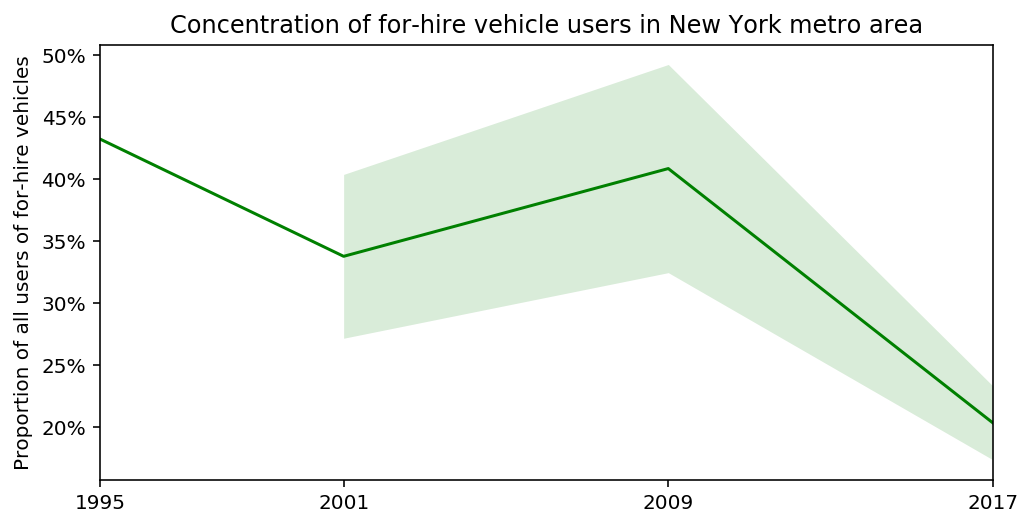

In [40]:
plt.figure(figsize=(8, 4))

plt.title('Concentration of for-hire vehicle users in New York metro area')
plt.ylabel('Proportion of all users of for-hire vehicles')

# plt.fill_between(
#     proportionUsersMSA3m.index,
#     proportionUsersMSA3m.est - proportionUsersMSA3m.se * 1.96,
#     proportionUsersMSA3m.est + proportionUsersMSA3m.se * 1.96,
#     color='purple',
#     alpha=0.15,
#     lw=0
# )
# plt.plot(proportionUsersMSA3m.index, proportionUsersMSA3m.est, label='Other MSAs over 3 million', color='purple')

# plt.fill_between(
#     proportionUsersMSA1to3m.index,
#     proportionUsersMSA1to3m.est - proportionUsersMSA1to3m.se * 1.96,
#     proportionUsersMSA1to3m.est + proportionUsersMSA1to3m.se * 1.96,
#     color='blue',
#     alpha=0.15,
#     lw=0
# )
# plt.plot(proportionUsersMSA1to3m.index, proportionUsersMSA1to3m.est, label='MSAs with 1–3 million people', color='blue')


# plt.fill_between(
#     proportionUsersNE.index,
#     proportionUsersNE.est - proportionUsersNE.se * 1.96,
#     proportionUsersNE.est + proportionUsersNE.se * 1.96,
#     color='orange',
#     alpha=0.15,
#     lw=0
# )
# plt.plot(proportionUsersNE.index, proportionUsersNE.est, label='Other major Eastern cities', color='orange')

proportionUsersNYC *= 100
plt.fill_between(
    proportionUsersNYC.index,
    proportionUsersNYC.est - proportionUsersNYC.se * 1.96,
    proportionUsersNYC.est + proportionUsersNYC.se * 1.96,
    color='green',
    alpha=0.15,
    lw=0
)
plt.plot(proportionUsersNYC.index, proportionUsersNYC.est, color='green', label='New York City metro area')

# plt.fill_between(
#     proportionUsersMSA1m.index,
#     proportionUsersMSA1m.est - proportionUsersMSA1m.se * 1.96,
#     proportionUsersMSA1m.est + proportionUsersMSA1m.se * 1.96,
#     color='#222222',
#     alpha=0.15,
#     lw=0
# )
#plt.plot(proportionUsersMSA1m.index, proportionUsersMSA1m.est, label='MSAs under 1 million/non-MSA', color='#222222')

plt.xticks([1995, 2001, 2009, 2017])
plt.xlim(1995, 2017)
plt.yticks(np.arange(20, 55, 5), [f'{i:d}%' for i in range(20, 55, 5)])
#plt.ylim(0, 1)

#plt.legend()
plt.savefig('../fig/geogconcentration_nyc.pdf', bbox_inches='tight')

## Print out numerical results for quoting in the paper

Print out the percentage of users in NY, the NE, MSAs over 3 million, and MSAs under 1 million, respectively. Note that these are in raw percentages, not proportions.

In [41]:
proportionUsersNYC['moe'] = proportionUsersNYC['se'] * 1.96
(proportionUsersNYC * 100).round(2)

,est,se,moe
1995,4321.80,NaN,NaN
2001,3377.20,336.77,660.06
2009,4084.37,427.90,838.69
2017,2034.55,151.66,297.25


In [42]:
proportionUsersNE['moe'] = proportionUsersNE.se * 1.96
(proportionUsersNE * 100).round(2)

,est,se,moe
1995,24.21,NaN,NaN
2001,18.34,2.88,5.64
2009,18.98,4.80,9.42
2017,18.51,2.40,4.70


In [43]:
proportionUsersMSA3m['moe'] = proportionUsersMSA3m.se * 1.96
(proportionUsersMSA3m * 100).round(2)

,est,se,moe
1995,6.60,NaN,NaN
2001,20.55,3.60,7.05
2009,19.24,4.10,8.04
2017,26.73,2.06,4.05


In [44]:
proportionUsersMSA1m['moe'] = proportionUsersMSA1m.se * 1.96
(proportionUsersMSA1m * 100).round(2)

,est,se,moe
1995,11.79,NaN,NaN
2001,19.85,3.61,7.07
2009,13.08,3.45,6.77
2017,16.80,1.77,3.47


In [45]:
pers17.msaSize.cat.categories

Index(['Not in MSA', 'Less than 250,000', '250,000 to 499,999',
       '500,000 to 999,999', '1,000,000 to 2,999,999', 'More than 3 million'],
      dtype='object')

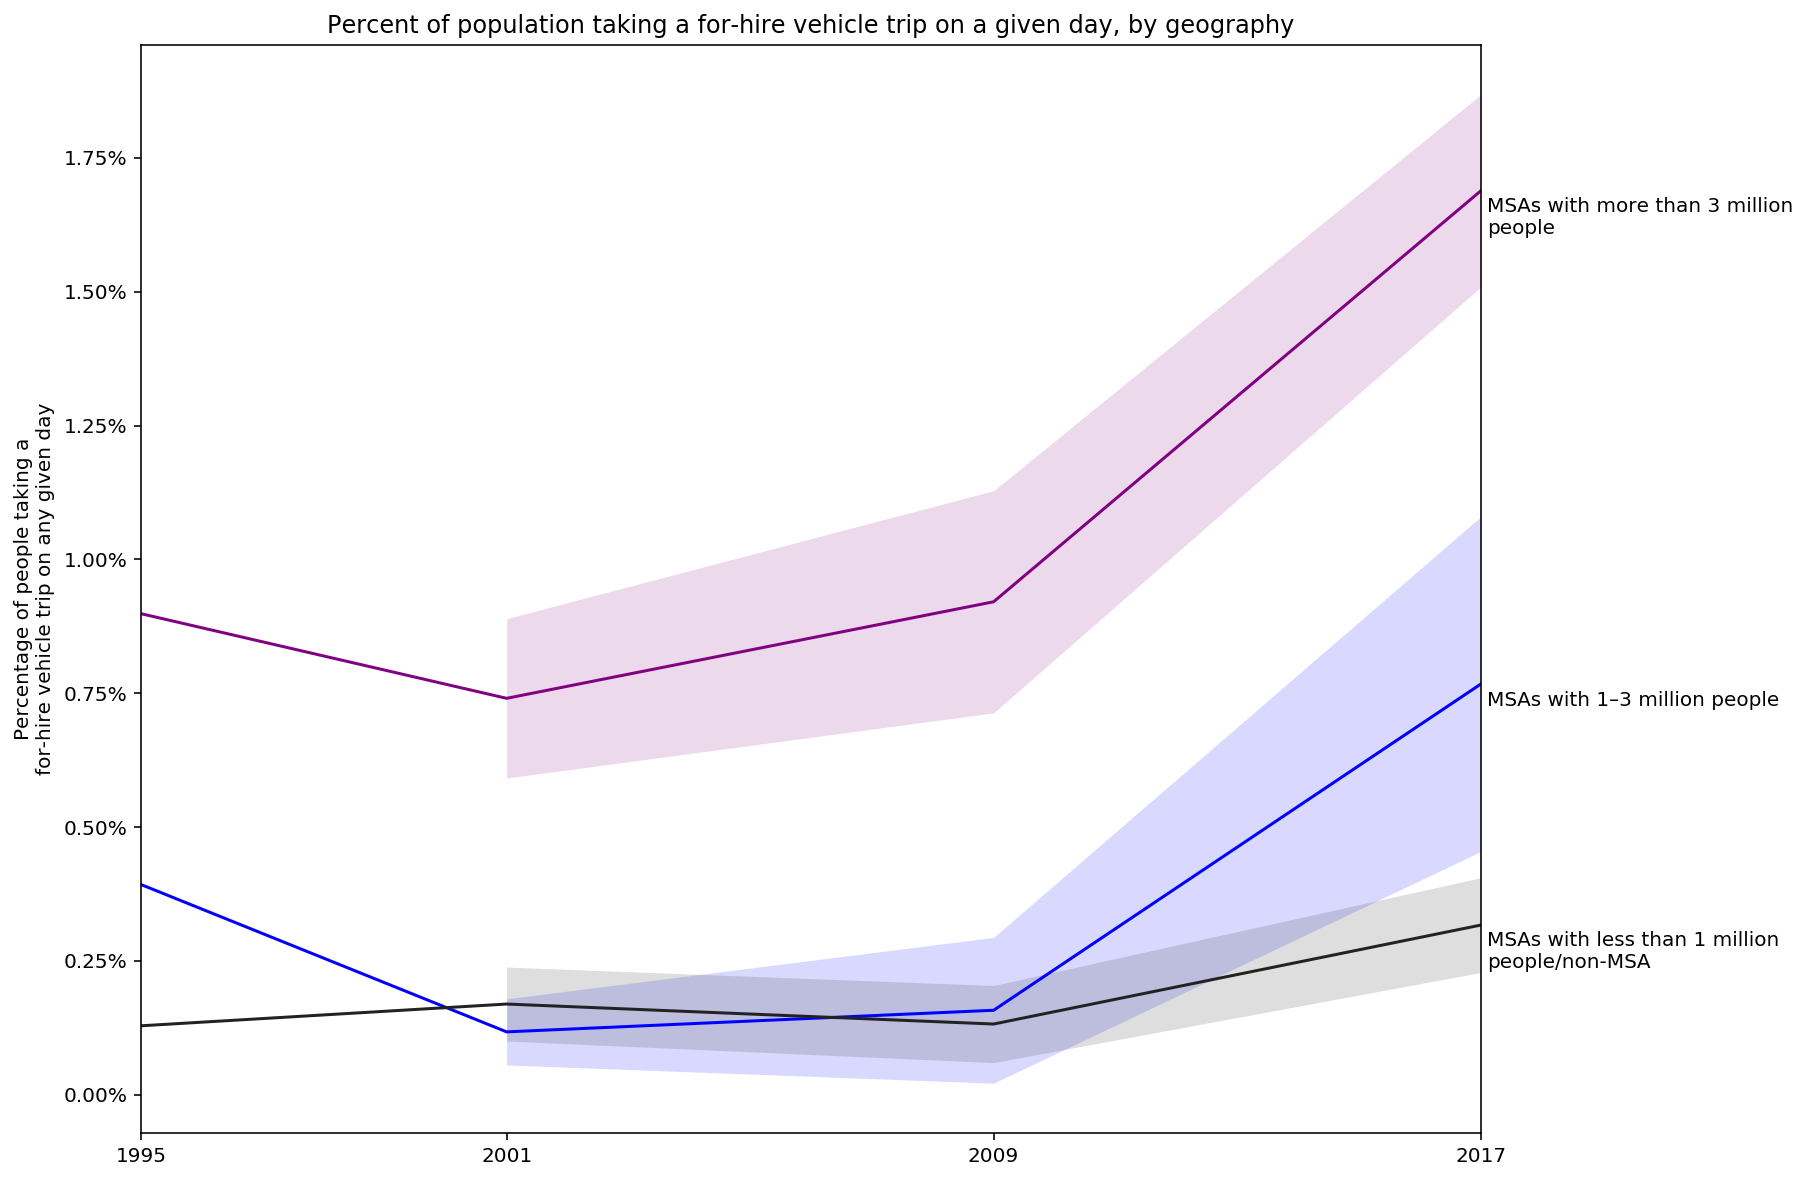

In [68]:
subsets95Gen = {}
subsets01Gen = {}
subsets09Gen = {}
subsets17Gen = {}

for year, dta, subsetsGen in [
    (1995, pers95, subsets95Gen),
    (2001, pers01, subsets01Gen),
    (2009, pers09, subsets09Gen),
    (2017, pers17, subsets17Gen)
]:
    inTown = dta.OUTCNTRY != 1 if year == 1995 else dta.OUTOFTWN != 1
    subsetsGen['MSAs with more than 3 million people'] = (dta.msaSize == 'More than 3 million')# & inTown
    subsetsGen['MSAs with 1–3 million people'] = (dta.msaSize == '1,000,000 to 2,999,999')# & inTown
    subsetsGen['MSAs with less than 1 million people/non-MSA'] = dta.msaSize.isin(less1m)# & inTown
    
plotBySubsets(subsets95Gen, subsets01Gen, subsets09Gen, subsets17Gen, colors = {
    'MSAs with less than 1 million people/non-MSA': '#222222',
    'MSAs with 1–3 million people': 'blue',
    'MSAs with more than 3 million people': 'purple',
    'Other major Eastern metropolitan areas (Boston, Chicago, and Washington, DC)': 'orange',
    'New York City metropolitan area': 'green',
    'Philadelphia metropolitan area': 'red'
},
              title='Percent of population taking a for-hire vehicle trip on a given day, by geography')#,
              #filename='../fig/geogusage_size.pdf')

### Break it down to individual cities

These will have huge error bars, but are useful to show how trends differ in cities that had robust taxi markets (NYC, Boston) or banned ridehailing (Philly) as opposed to those that didn't (DC, San Francisco, Chicago).

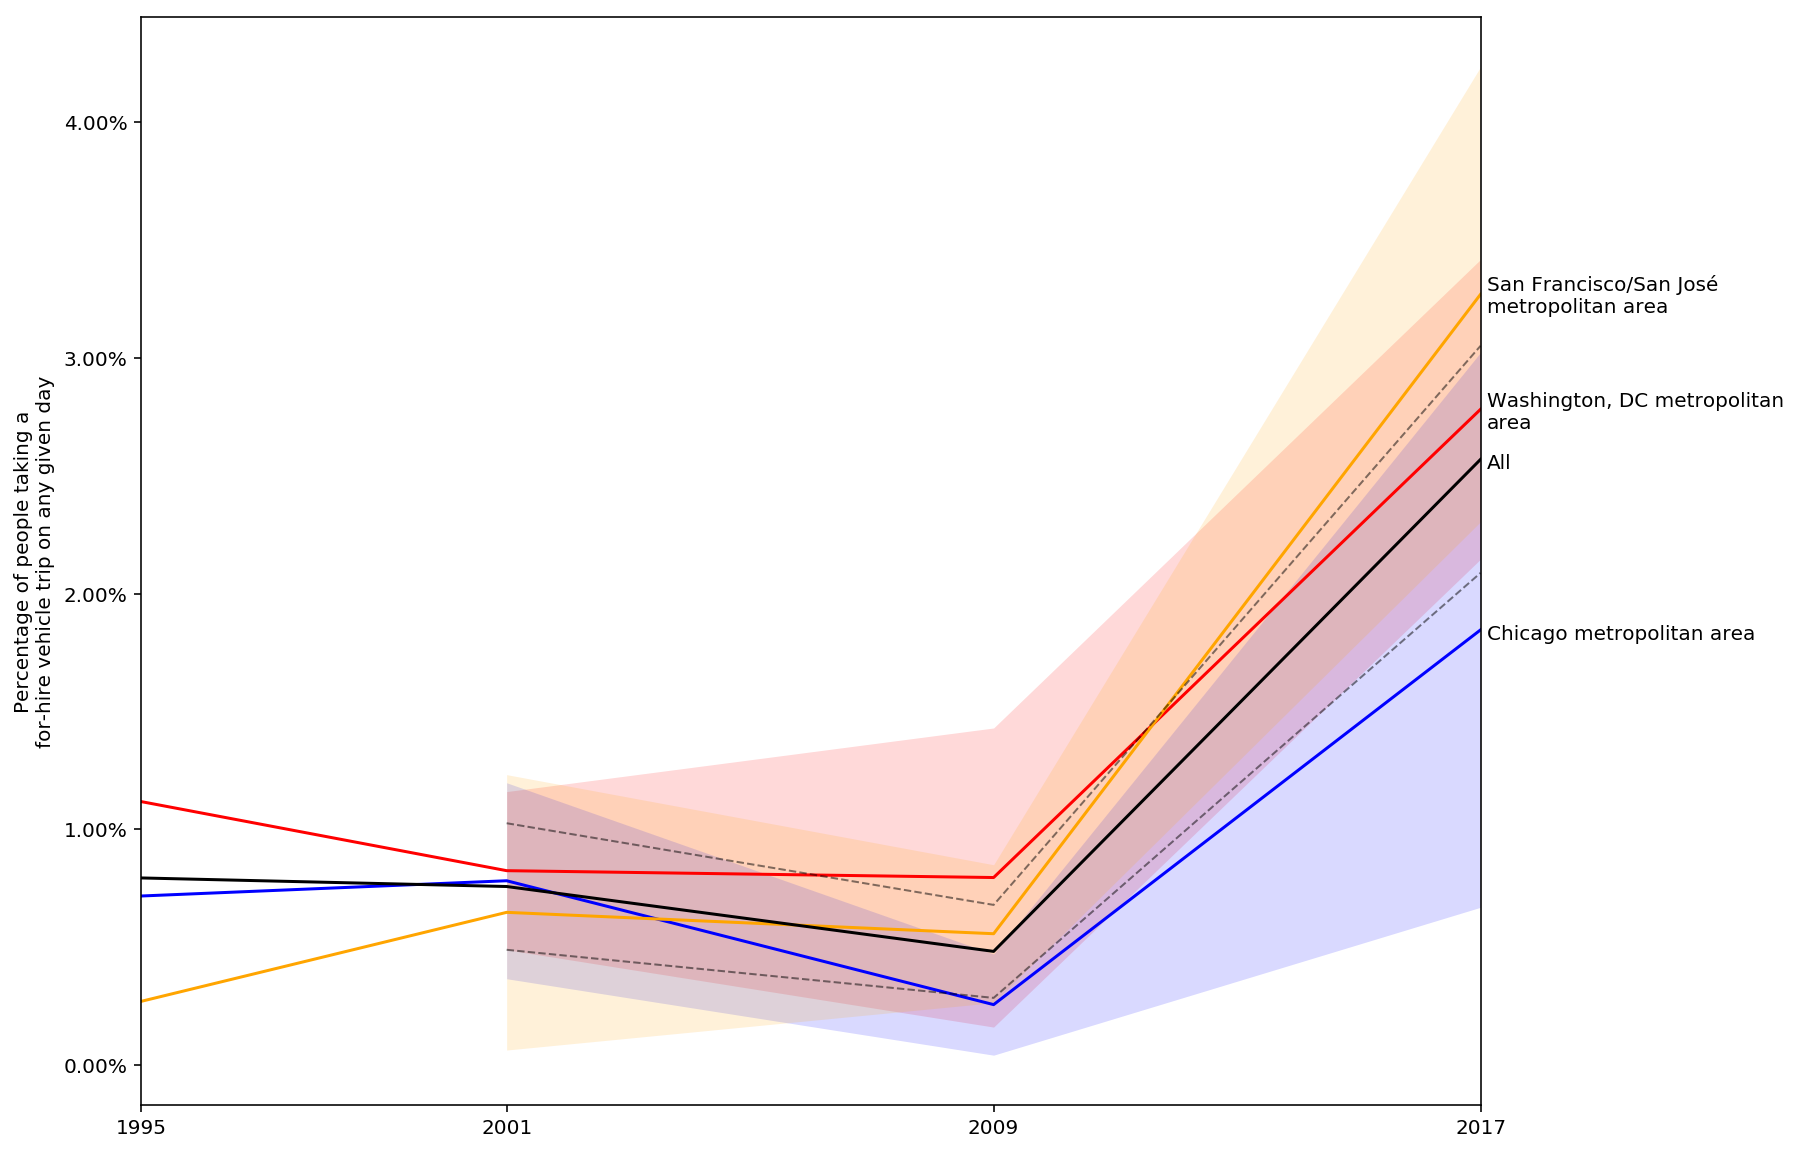

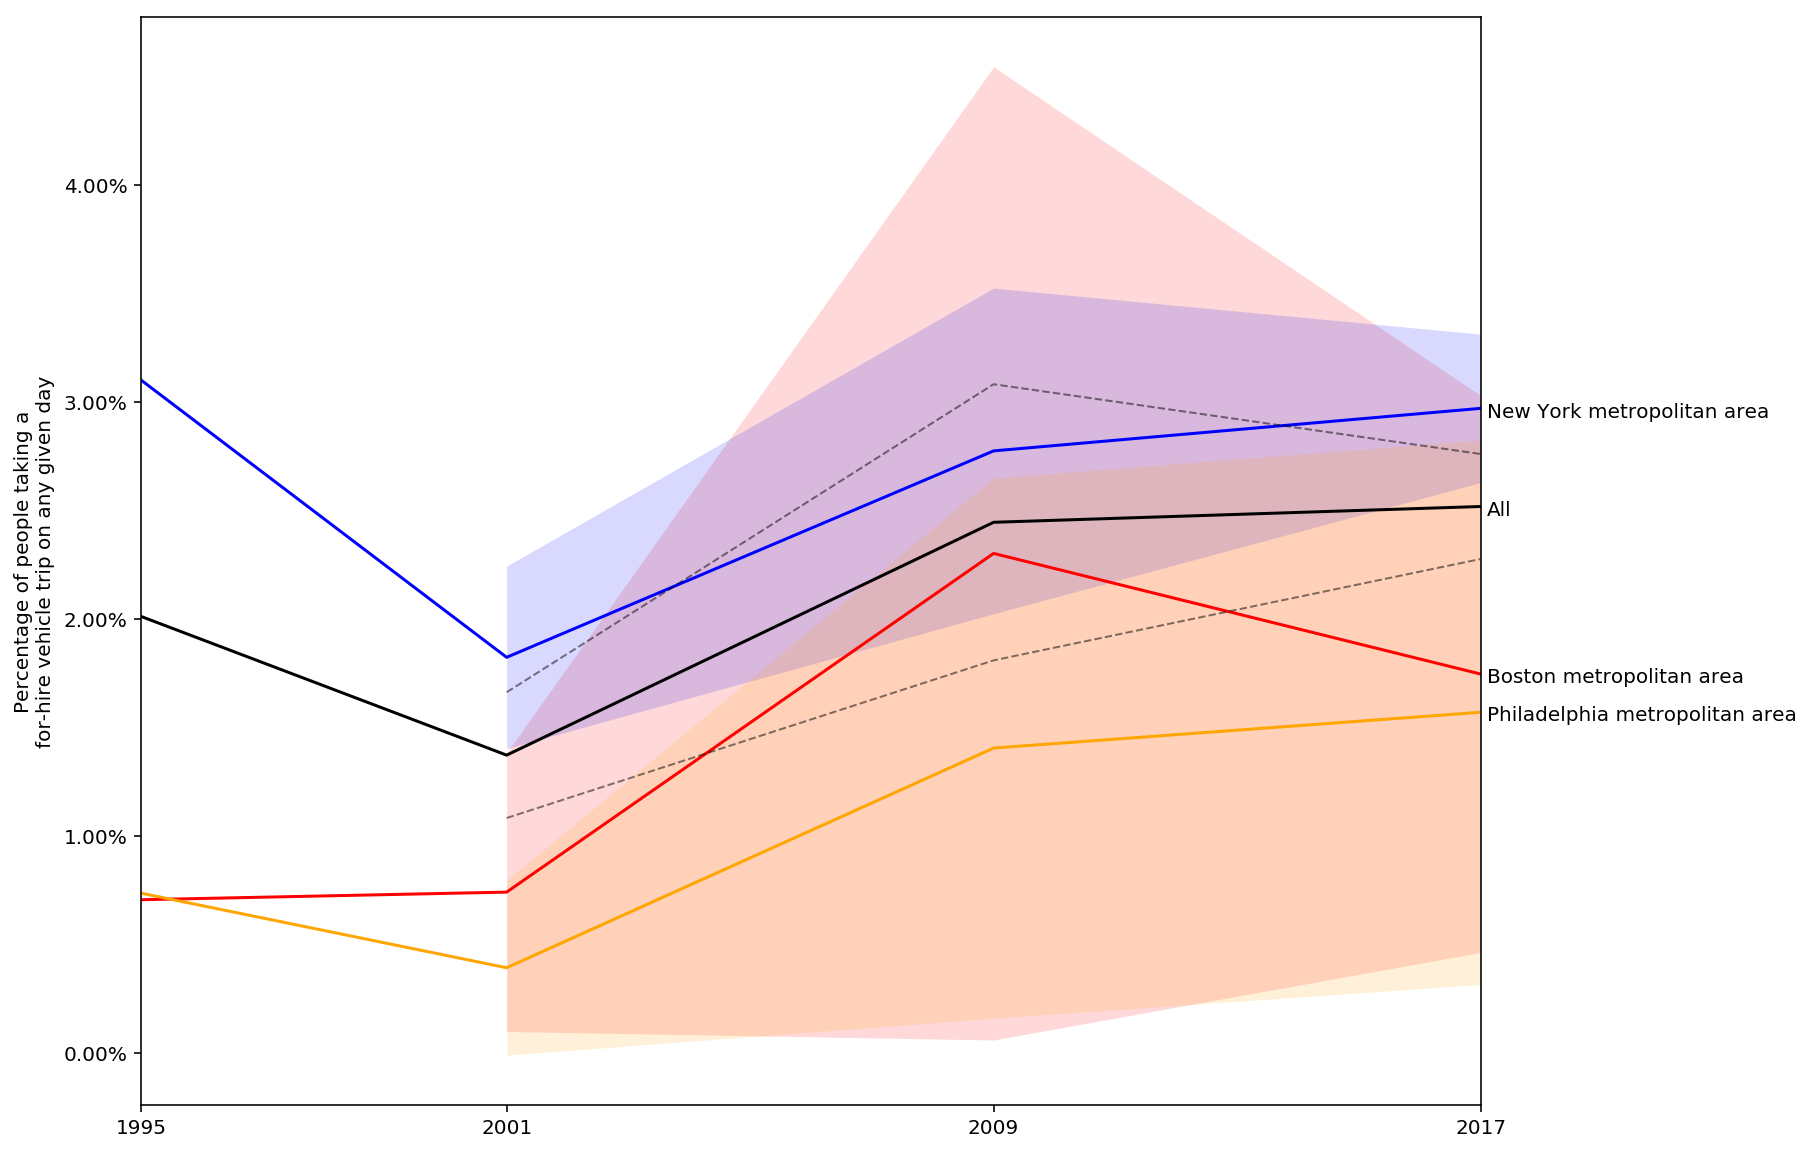

In [47]:
citiesByYear = {
    2017: {
        'BOS': ('HH_CBSA', '14460'),
        'DCA': ('HH_CBSA', '47900'),
        'ORD': ('HH_CBSA', '16980'),
        'JFK': ('HH_CBSA', '35620'),
        'SFO': ('HH_CBSA', ['41860', '41940']), # San Francisco and San José really function as a single metro
        'PHL': ('HH_CBSA', '37980')
    },
    2009: {
        'BOS': ('HH_CBSA', '14460'),
        'DCA': ('HH_CBSA', '47900'),
        'ORD': ('HH_CBSA', '16980'),
        'JFK': ('HH_CBSA', '35620'),
        'SFO': ('HH_CBSA', ['41860', '41940']),
        'PHL': ('HH_CBSA', '37980')
    },
    2001: {
        'BOS': ('HHC_MSA', '1122'),
        'DCA': ('HHC_MSA', '8872'),
        'ORD': ('HHC_MSA', '1602'),
        'JFK': ('HHC_MSA', '5602'),
        'SFO': ('HHC_MSA', '7362'), # San Francisco and San José were together in 2001
        'PHL': ('HHC_MSA', '6162')
    },
    1995: {
        'BOS': ('HHMSA', 1123),
        'DCA': ('HHCMSA', 8872),
        'ORD': ('HHCMSA', 1602),
        'JFK': ('HHCMSA', 5602),
        'SFO': ('HHCMSA', 7362),
        'PHL': ('HHCMSA', 6162)
    }
}

cityNames = {
    'BOS': 'Boston metropolitan area',
    'DCA': 'Washington, DC metropolitan area',
    'ORD': 'Chicago metropolitan area',
    'JFK': 'New York metropolitan area',
    'SFO': 'San Francisco/San José metropolitan area',
    'PHL': 'Philadelphia metropolitan area'
}

subsets95 = {0: {}, 1: {}}
subsets01 = {0: {}, 1: {}}
subsets09 = {0: {}, 1: {}}
subsets17 = {0: {}, 1: {}}

plot1 = ['PHL', 'BOS', 'JFK']

for year, dta, subsets in [
    (1995, pers95, subsets95),
    (2001, pers01, subsets01),
    (2009, pers09, subsets09),
    (2017, pers17, subsets17)
]:
    for city, criterion in citiesByYear[year].items():
        if isinstance(criterion[1], list):
            subset = dta[criterion[0]].isin(criterion[1])
        else:
            subset = dta[criterion[0]] == criterion[1]
        
        if city in plot1:
            subsets[1][cityNames[city]] = subset
        else:
            subsets[0][cityNames[city]] = subset
            
    # Make a composite category in each set of subsets
    for plot in [0, 1]:
        subsetLabels = list(subsets[plot].keys())
        composite = subsets[plot][subsetLabels[0]].copy()
        for key in subsetLabels[1:]:
            composite |= subsets[plot][key]
        subsets[plot]['All'] = composite

# This is the chart of cities where Matt's lived...
plotBySubsets(subsets95[0], subsets01[0], subsets09[0], subsets17[0], colors={
    'Chicago metropolitan area': 'blue', # Go Cubs!
    'Washington, DC metropolitan area': 'red', # Go Nats!
    'San Francisco/San José metropolitan area': 'orange', # Go Giants!
    'All': 'black'
}, outlines=['All'], filename='../fig/cityincreases.pdf')


plotBySubsets(subsets95[1], subsets01[1], subsets09[1], subsets17[1], colors={
    'New York metropolitan area': 'blue',
    'Boston metropolitan area': 'red', # Go Sox!
    'Philadelphia metropolitan area': 'orange',
    'All': 'black'
}, outlines=['All'], filename='../fig/cityflat.pdf')

#### Repeat the income figures for different MSA sizes

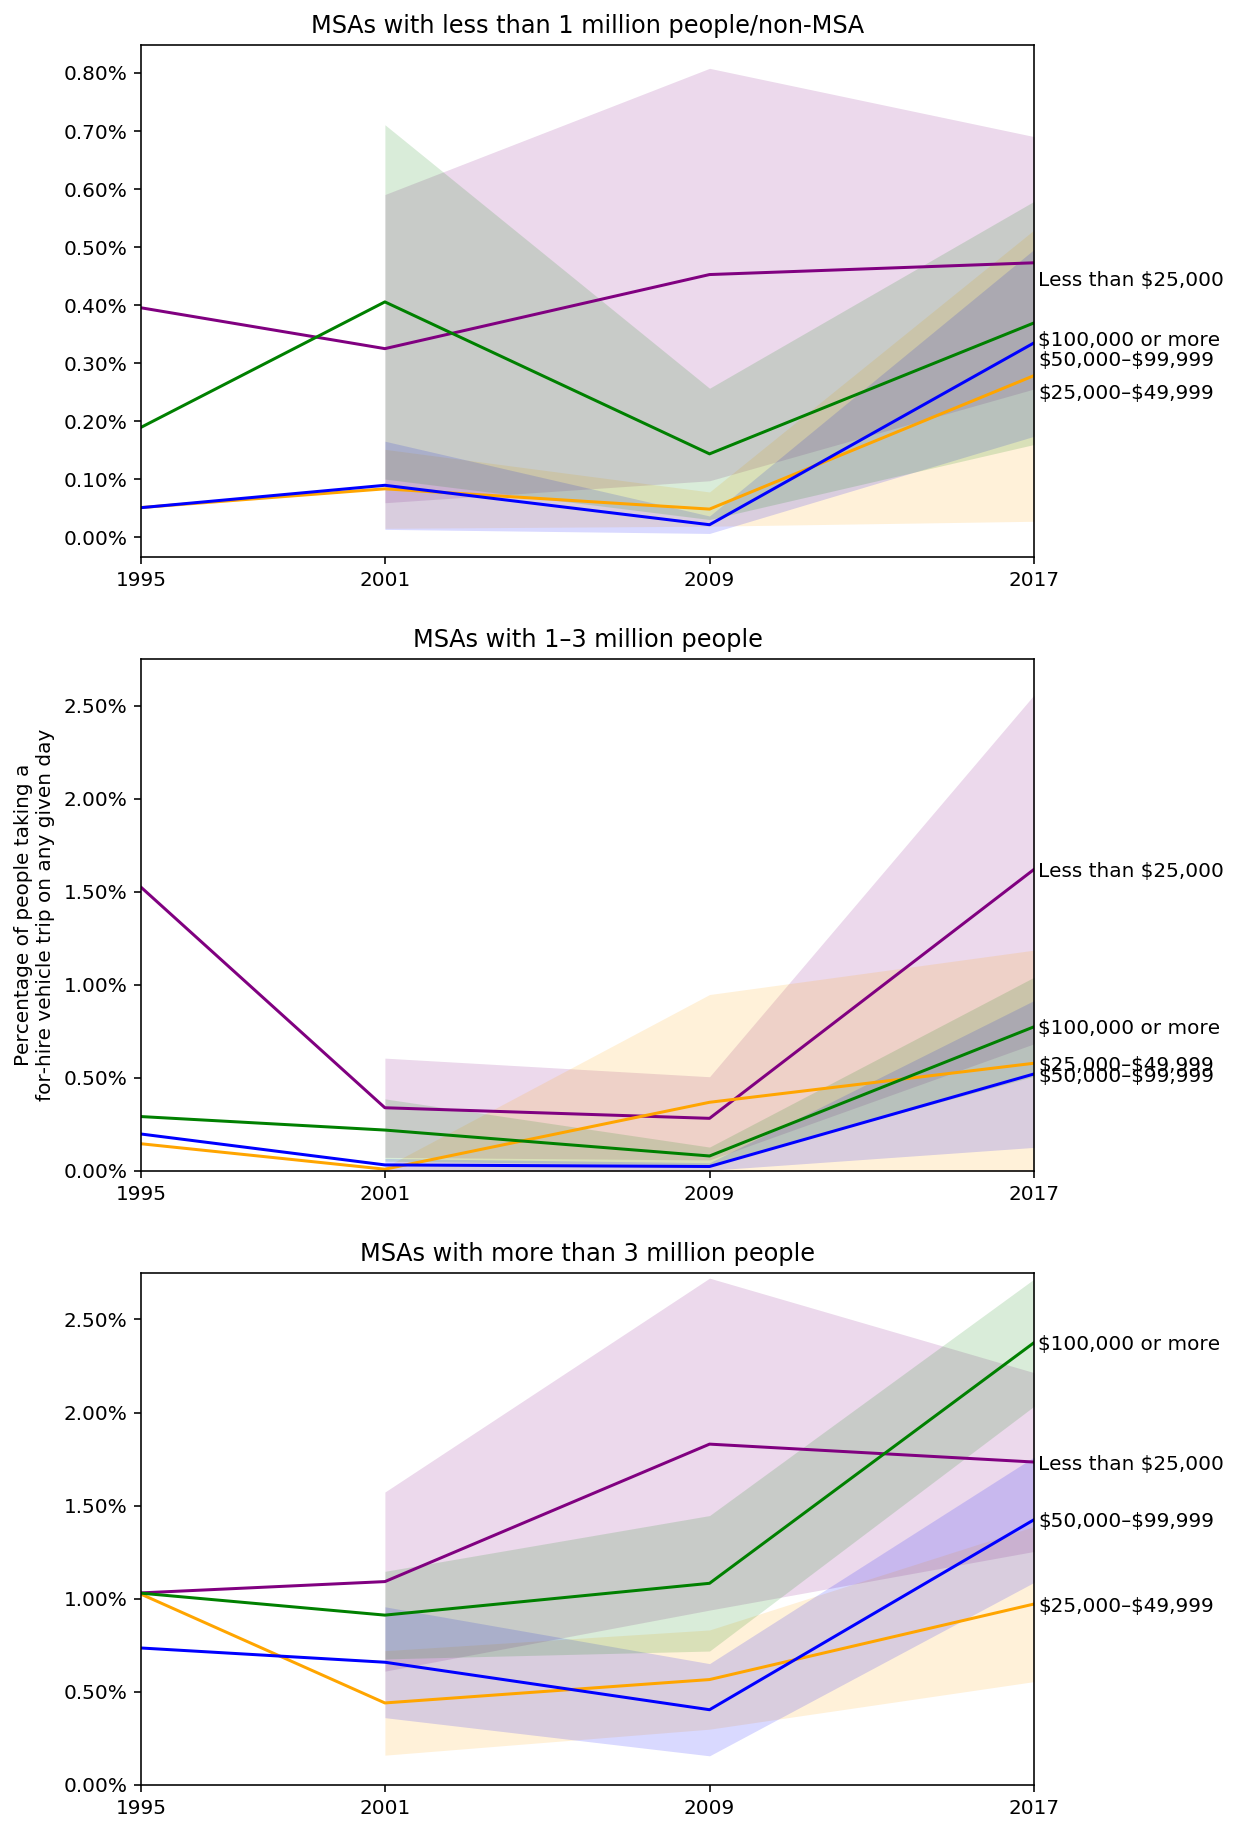

In [48]:
plt.subplots(figsize = (8, 16))
for i, msaSizeLabel, msaSizeValues in [
    (3, 'MSAs with more than 3 million people', ['More than 3 million']),
    (2, 'MSAs with 1–3 million people', ['1,000,000 to 2,999,999']),
    (1, 'MSAs with less than 1 million people/non-MSA', less1m)
]:
    ax = plt.subplot(3, 1, i)
    plotBySubsets(
    # not all years used the same income labels, due to CPI adjustment, but they use the same categories
    # in the same orders
    *[{
        'Less than \$25,000': (dta.incomeCategory == dta.incomeCategory.cat.categories[0]) & dta.msaSize.isin(msaSizeValues),
        '\$25,000–\$49,999': (dta.incomeCategory == dta.incomeCategory.cat.categories[1]) & dta.msaSize.isin(msaSizeValues),
        '\$50,000–\$99,999': (dta.incomeCategory == dta.incomeCategory.cat.categories[2]) & dta.msaSize.isin(msaSizeValues),
        '\$100,000 or more': (dta.incomeCategory == dta.incomeCategory.cat.categories[3]) & dta.msaSize.isin(msaSizeValues)
    } for dta in [pers95, pers01, pers09, pers17]],
    colors={
        'Less than \$25,000': 'purple',
        '\$25,000–\$49,999': 'orange',
        '\$50,000–\$99,999': 'blue',
        '\$100,000 or more': 'green'
    },
    ax=ax,
    title=msaSizeLabel
    )  
    
    if len(msaSizeValues) == 1:
        # don't apply to small MSAs as all variation gets lost
        plt.ylim(0, 2.75)
    
    if i != 2:
        plt.ylabel('')
        
plt.savefig('../fig/income_msasize.pdf', bbox_inches='tight')

### Demographics by geography

The error in 2009 is really quite large, due to low numbers of taxi trips recorded (_cf._ http://phdcomics.com/comics.php?f=1816).

In [49]:
colnames = [
    'MSAs with less than 3 million people/non-MSA',
    'MSAs with more than 3 million people, except New York',
    'New York City metropolitan area'
]

# Use a reduced number of categories for larger sample sizes and smaller standard errors
subsets09r = {
    'MSAs with less than 3 million people/non-MSA': pers09.msaSize != 'More than 3 million',
    'MSAs with more than 3 million people, except New York': (pers09.msaSize == 'More than 3 million') & (pers09.HH_CBSA != '35620'),
    'New York City metropolitan area': pers09.HH_CBSA != '35620'
}

subsets17r = {
    'MSAs with less than 3 million people/non-MSA': pers17.msaSize != 'More than 3 million',
    'MSAs with more than 3 million people, except New York': (pers17.msaSize == 'More than 3 million') & (pers17.HH_CBSA != '35620'),
    'New York City metropolitan area': pers17.HH_CBSA != '35620'
}


# Use short colnames and rename for display, to make manipulation easier
dgtable = pd.DataFrame(columns=colnames, index=pd.MultiIndex.from_product([
    [
        '29 or under',
        '30–49',
        '50+',
        r'Less than \$25,000',
        r'\$25,000–\$49,999',
        r'\$50,000–\$99,999',
        r'\$100,000 or more',
        'Male',
        'One or more vehicle per driver'
    ],
    [
        '2009',
        '2017 (All for-hire vehicles)',
        '2017 (Ridehailing only)'
    ]
]))

for year, row, dta, subsets in [
    (2009, '2009', pers09, subsets09r),
    (2017, '2017 (All for-hire vehicles)', pers17, subsets17r),
    (2017, '2017 (Ridehailing only)', pers17, subsets17r),
]:
    
    for subsetLabel, subset in subsets.items():
        if row == '2017 (Ridehailing only)':
            taxiSubset = subset & (dta.RIDESHARE > 0)
        else:
            taxiSubset = subset & dta.taxi
            
        # Start with age
        dgtable.loc[('29 or under', row), subsetLabel] = computeValueAndSE(
            dta[(dta.R_AGE >= 0) & (dta.R_AGE < 30) & taxiSubset],
            dta[taxiSubset & (dta.R_AGE >= 0)],
            year
        )
        
        dgtable.loc[('30–49', row), subsetLabel] = computeValueAndSE(
            dta[(dta.R_AGE >= 30) & (dta.R_AGE < 50) & taxiSubset],
            dta[taxiSubset & (dta.R_AGE >= 0)],
            year
        )
    
        dgtable.loc[('50+', row), subsetLabel] = computeValueAndSE(
            dta[(dta.R_AGE >= 50) & taxiSubset],
            dta[taxiSubset & (dta.R_AGE >= 0)],
            year
        )
        
        oneOrMoreVehPerDriver = dta.HHVEHCNT / dta.DRVRCNT >= 1
        dgtable.loc[('One or more vehicle per driver', row), subsetLabel] = computeValueAndSE(
            dta[oneOrMoreVehPerDriver & taxiSubset],
            dta[taxiSubset],
            year
        )
        
        dgtable.loc[('Male', row), subsetLabel] = computeValueAndSE(
            dta[(dta.R_SEX == 1) & taxiSubset],
            dta[(dta.R_SEX > 0) & taxiSubset],
            year
        )
        
        dgtable.loc[(r'Less than \$25,000', row), subsetLabel] = computeValueAndSE(
            dta[(dta.incomeCategory == dta.incomeCategory.cat.categories[0]) & taxiSubset],
            dta[~pd.isnull(dta.incomeCategory) & taxiSubset],
            year
        )
        
        dgtable.loc[(r'\$25,000–\$49,999', row), subsetLabel] = computeValueAndSE(
            dta[(dta.incomeCategory == dta.incomeCategory.cat.categories[1]) & taxiSubset],
            dta[~pd.isnull(dta.incomeCategory) & taxiSubset],
            year
        )
            
        dgtable.loc[(r'\$50,000–\$99,999', row), subsetLabel] = computeValueAndSE(
            dta[(dta.incomeCategory == dta.incomeCategory.cat.categories[2]) & taxiSubset],
            dta[~pd.isnull(dta.incomeCategory) & taxiSubset],
            year
        )
        
        dgtable.loc[(r'\$100,000 or more', row), subsetLabel] = computeValueAndSE(
            dta[(dta.incomeCategory == dta.incomeCategory.cat.categories[3]) & taxiSubset],
            dta[~pd.isnull(dta.incomeCategory) & taxiSubset],
            year
        )

dgtable.to_latex('demographics_geography.tex', escape=False)
dgtable

MSAs with less than 3 million people/non-MSA  \
29 or under                    2009                                                  $27.65\% \pm 27.16$   
                               2017 (All for-hire vehicles)                          $37.21\% \pm 12.42$   
                               2017 (Ridehailing only)                                $39.04\% \pm 1.87$   
30–49                          2009                                                  $24.53\% \pm 17.18$   
                               2017 (All for-hire vehicles)                           $27.57\% \pm 5.68$   
                               2017 (Ridehailing only)                                $41.67\% \pm 1.76$   
50+                            2009                                                  $47.82\% \pm 24.48$   
                               2017 (All for-hire vehicles)                          $35.22\% \pm 14.65$   
                               2017 (Ridehailing only)                                $19.28\% \pm 1.63$   
Less than \$25,000             2009                                                  $49.44\% \pm 26.03$   
                               2017 (All for-hire vehicles)                           $34.21\% \pm 7.20$   
                               2017 (Ridehailing only)                                $15.81\% \pm 4.28$   
\$25,000–\$49,999              2009                                                  $25.78\% \pm 28.21$   
                               2017 (All for-hire vehicles)                           $16.08\% \pm 6.47$   
                               2017 (Ridehailing only)                                $17.34\% \pm 3.31$   
\$50,000–\$99,999              2009                                                    $4.38\% \pm 3.24$   
                               2017 (All for-hire vehicles)                           $23.49\% \pm 8.76$   
                               2017 (Ridehailing only)                                $25.89\% \pm 1.72$   
\$100,000 or more              2009                                                  $20.40\% \pm 14.73$   
                               2017 (All for-hire vehicles)                           $26.22\% \pm 7.82$   
                               2017 (Ridehailing only)                                $40.95\% \pm 4.03$   
Male                           2009                                                  $44.09\% \pm 24.31$   
                               2017 (All for-hire vehicles)                           $40.59\% \pm 7.80$   
                               2017 (Ridehailing only)                                $53.13\% \pm 2.42$   
One or more vehicle per driver 2009                                                  $45.84\% \pm 25.85$   
                               2017 (All for-hire vehicles)                          $52.11\% \pm 12.92$   
                               2017 (Ridehailing only)                                $80.53\% \pm 4.75$   

                                                            MSAs with more than 3 million people, except New York  \
29 or under                    2009                                                        $23.39\% \pm 15.39$      
                               2017 (All for-hire vehicles)                                 $38.69\% \pm 6.46$      
                               2017 (Ridehailing only)                                      $33.87\% \pm 2.23$      
30–49                          2009                                                        $59.35\% \pm 19.28$      
                               2017 (All for-hire vehicles)                                 $40.67\% \pm 4.59$      
                               2017 (Ridehailing only)                                      $47.21\% \pm 2.03$      
50+                            2009                                                         $17.26\% \pm 9.71$      
                               2017 (All for-hire vehicles)                                 $20.65\

Check if the differences in high-income individuals is only due to differences in the city income distribution.

In [50]:
for year, dta, subsets in [
    (2009, pers09, subsets09r),
    (2017, pers17, subsets17r),
]:
    for subsetLabel, subset in subsets.items():
        val = computeValueAndSE(
                dta[(dta.incomeCategory == dta.incomeCategory.cat.categories[3]) & subset],
                dta[~pd.isnull(dta.incomeCategory) & subset],
                year
            )
        print(f'{subsetLabel}, {year}: {val} of residents had incomes over $100,000')


MSAs with less than 3 million people/non-MSA, 2009: $26.12\% \pm 0.81$ of residents had incomes over $100,000
MSAs with more than 3 million people, except New York, 2009: $37.02\% \pm 1.25$ of residents had incomes over $100,000
New York City metropolitan area, 2009: $29.64\% \pm 0.72$ of residents had incomes over $100,000
MSAs with less than 3 million people/non-MSA, 2017: $24.95\% \pm 1.02$ of residents had incomes over $100,000
MSAs with more than 3 million people, except New York, 2017: $38.75\% \pm 1.13$ of residents had incomes over $100,000
New York City metropolitan area, 2017: $29.19\% \pm 0.56$ of residents had incomes over $100,000


### What about trip purposes? Do those vary across metro areas?

In [51]:
for dta in [trips17, trips09, trips01, trips95]:
    # WHYTRP90: 1990 trip purpose, consistent across NHTS waves
    dta['tripPurpose'] = dta.WHYTRP90.replace({
        1: 'Work/work-related', # Work
        2: 'Work/work-related', # 'Work-related business',
        3: 'Shopping',
        4: 'Other Family/Personal Business',
        5: 'School/Church',
        6: 'Medical/Dental', # Dentral is what it says in the codebook...
        7: 'Vacation',
        8: 'Social/Recreational', #'Visit Friends/Relatives',
        10: 'Social/Recreational', #'Other Social/Recreational',
        11: 'Other',
        98: np.nan,
        99: np.nan
    }).astype('category')
    
msaSizeCats = [
    (1, 'MSAs with less than 1 million people/non-MSA', less1m),
    (2, 'MSAs with 1–3 million people', ['1,000,000 to 2,999,999']),
        (3, 'MSAs with more than 3 million people', ['More than 3 million'])
]

catLabels = [l for i, l, c in msaSizeCats]
    
tripPurpSum = pd.DataFrame(columns=['Social/Recreational', 'Work/work-related', 'Medical/Dental',
                                    'Shopping', 'School/Church', 'Other Family/Personal Business',
        'Other'], index=pd.MultiIndex.from_product([
    trips17.incomeCategory.cat.categories,
    catLabels
]))

for year, dta in [
    (2017, trips17)
]:  
    for incomeCat in trips17.incomeCategory.cat.categories:
        for tripPurp in dta.tripPurpose.cat.categories:
            if tripPurp == 'Vacation':
                continue
                
            for i, msaSizeLabel, msaSizeValues in msaSizeCats:
                taxiTripsInCat = dta.TRPTRANS.isin(TAXI_MODE[year]) & dta.msaSize.isin(msaSizeValues) &\
                    (dta.incomeCategory == incomeCat)
                tripPurpSum.loc[(incomeCat, msaSizeLabel), tripPurp] = computeValueAndSE(
                    dta[taxiTripsInCat & (dta.tripPurpose == tripPurp) ],
                    dta[taxiTripsInCat],
                    year
                )

tripPurpSum.to_latex('trip_purp_by_msa.tex', escape=False)
tripPurpSum


Social/Recreational  \
Less than \$25,000 MSAs with less than 1 million people/non-MSA  $16.75\% \pm 18.14$   
                   MSAs with 1–3 million people                  $16.36\% \pm 24.78$   
                   MSAs with more than 3 million people          $21.96\% \pm 16.02$   
\$25,000--\$49,999 MSAs with less than 1 million people/non-MSA  $14.59\% \pm 16.04$   
                   MSAs with 1–3 million people                  $16.37\% \pm 18.33$   
                   MSAs with more than 3 million people          $40.02\% \pm 21.90$   
\$50,000--\$99,999 MSAs with less than 1 million people/non-MSA  $14.96\% \pm 27.13$   
                   MSAs with 1–3 million people                  $60.60\% \pm 20.30$   
                   MSAs with more than 3 million people          $24.09\% \pm 29.16$   
\$100,000 or more  MSAs with less than 1 million people/non-MSA  $13.02\% \pm 14.60$   
                   MSAs with 1–3 million people                  $59.41\% \pm 28.33$   
                   MSAs with more than 3 million people          $47.69\% \pm 12.01$   

                                                                   Work/work-related  \
Less than \$25,000 MSAs with less than 1 million people/non-MSA  $25.79\% \pm 26.89$   
                   MSAs with 1–3 million people                  $29.45\% \pm 17.52$   
                   MSAs with more than 3 million people           $12.58\% \pm 7.90$   
\$25,000--\$49,999 MSAs with less than 1 million people/non-MSA  $31.68\% \pm 38.96$   
                   MSAs with 1–3 million people                  $36.43\% \pm 13.30$   
                   MSAs with more than 3 million people          $24.49\% \pm 13.05$   
\$50,000--\$99,999 MSAs with less than 1 million people/non-MSA  $16.19\% \pm 34.21$   
                   MSAs with 1–3 million people                  $18.23\% \pm 38.28$   
                   MSAs with more than 3 million people          $39.27\% \pm 21.81$   
\$100,000 or more  MSAs with less than 1 million people/non-MSA  $65.29\% \pm 30.37$   
                   MSAs with 1–3 million people                  $12.21\% \pm 10.07$   
                   MSAs with more than 3 million people           $25.80\% \pm 9.56$   

                                                                      Medical/Dental  \
Less than \$25,000 MSAs with less than 1 million people/non-MSA  $17.01\% \pm 11.43$   
                   MSAs with 1–3 million people                  $27.15\% \pm 41.18$   
                   MSAs with more than 3 million people          $25.84\% \pm 18.55$   
\$25,000--\$49,999 MSAs with less than 1 million people/non-MSA  $10.95\% \pm 15.29$   
                   MSAs with 1–3 million people                   $9.42\% \pm 38.98$   
                   MSAs with more than 3 million people           $7.06\% \pm 10.47$   
\$50,000--\$99,999 MSAs with less than 1 million people/non-MSA    $5.71\% \pm 9.97$   
                   MSAs with 1–3 million people                    $0.09\% \pm 0.25$   
                   MSAs with more than 3 million people            $2.57\% \pm 3.52$   
\$100,000 or more  MSAs with less than 1 million people/non-MSA    $0.64\% \pm 0.89$   
                   MSAs with 1–3 million people                    $0.47\% \pm 0.98$   
                   MSAs with more than 3 million people            $1.06\% \pm 1.04$   

                                                                            Shopping  \
Less than \$25,000 MSAs with less than 1 million people/non-MSA   $14.93\% \pm 9.66$   
                   MSAs with 1–3 million people                  $14.86\% \pm 19.53$   
                   MSAs with more than 3 million people          $20.04\% \pm 11.14$   
\$25,000--\$49,999 MSAs with less than 1 million people/non-MSA  $35.43\% \pm 58.12$   
                   MSAs with 1–3 million people                    $3.05\% \pm 8.52$   
                   MSAs with more than 3 million people           $14.59\% \pm 9.29$   
\$50,000--\$99

## What percent of FHV trips are on the weekends?

Getting this right requires careful treatment of after-midnight trips. In 2017, anyhow, the Trip Start Time is the clock time at which the trip started. But since the travel day starts at 4 AM, any trips between midnight and 3:59 AM actually did not occur on the travel calendar day, but on the day after. So a trip on Thursday at 3 AM actually occurred Friday at 3AM. Confirmed via personal communication with Apara Banerjee and Stacey Bricka at NHTS/MacroSysRT.

This is also confirmed below (checking that no person has trips on more than one day of the week).

In [52]:
for trips, year in [
    (trips95, 1995),
    (trips01, 2001),
    (trips09, 2009),
    (trips17, 2017)]:
    
    grpd = trips.groupby(('HOUSEID', 'PERSONID')).TRAVDAY.agg(lambda x: len(np.unique(x)))
    mx = max(grpd)
    print(f'{year}: {mx}')

1995: 1.0
2001: 1
2009: 1
2017: 1


In [53]:
fhvWeekend = pd.DataFrame(dict(proportion=np.zeros(4), se=np.zeros(4)), index=[1995, 2001, 2009, 2017])

for trips, year in [
    (trips95, 1995),
    (trips01, 2001),
    (trips09, 2009),
    (trips17, 2017)]:
    trips['dayOfWeek'] = trips.TRAVDAY.replace({
        1: 'Sunday',
        2: 'Monday',
        3: 'Tuesday',
        4: 'Wednesday',
        5: 'Thursday',
        6: 'Friday',
        7: 'Saturday'
    }).astype('category')
    
    # Use corrected start time in 1995 NPTS
    timecol = 'STRTTIM2' if 'STRTTIM2' in trips.columns else 'STRTTIME'
    
    if year == 1995:
        taxi = trips[trips.TRPTRANS.isin(TAXI_MODE[year]) & (trips[timecol] > 0)].copy()
    elif year == 2001 or year == 2009:
        #  missing is negative
        taxi = trips[trips.TRPTRANS.isin(TAXI_MODE[year]) & (trips[timecol] >= 0)].copy()
    elif year == 2017:
        taxi = trips[trips.TRPTRANS.isin(TAXI_MODE[year])].copy() # no missing data in 2017
        
    taxi['weekend'] = taxi.dayOfWeek.isin(['Thursday', 'Friday', 'Saturday']) &\
                                 ((taxi[timecol] >= 1800) | (taxi[timecol] <= 300))
    
    fhvWeekend.loc[year, 'proportion'] = np.sum(taxi[taxi.weekend][WEIGHTS[year]]) / np.sum(taxi[WEIGHTS[year]])
    if year == 1995:
        fhvWeekend.loc[year, 'se'] = np.nan
    else:
        fhvWeekend.loc[year, 'se'] = estReplicateSE(
            lambda i: np.sum(taxi[taxi.weekend][f'{REP_WEIGHTS[year]}{i}']) / np.sum(taxi[f'{REP_WEIGHTS[year]}{i}']),
            fhvWeekend.loc[year, 'proportion'],
            year
        )
    
fhvWeekend['moe'] = fhvWeekend.se * 1.96
fhvWeekend *= 100 # convert to percent

Text(0,0.5,'Percent of trips taken during the weekend')

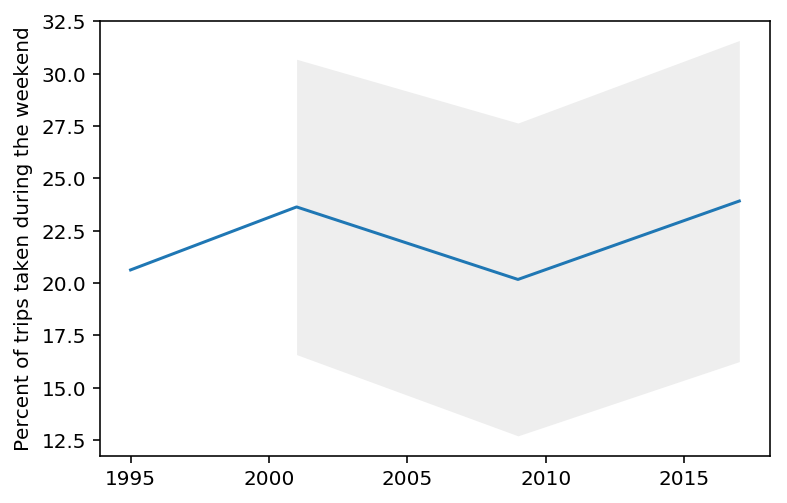

In [54]:
plt.fill_between(fhvWeekend.index, fhvWeekend.proportion - fhvWeekend.moe, fhvWeekend.proportion + fhvWeekend.moe,
                 color='#eeeeee', lw=0)
plt.plot(fhvWeekend.index, fhvWeekend.proportion)
plt.ylabel('Percent of trips taken during the weekend')

In [55]:
fhvWeekend

,proportion,se,moe
1995,20.627152,NaN,NaN
2001,23.636349,3.599368,7.054761
2009,20.172221,3.812273,7.472055
2017,23.918253,3.913286,7.670041


## Do people use for-hire vehicles a lot more when they are out of town?

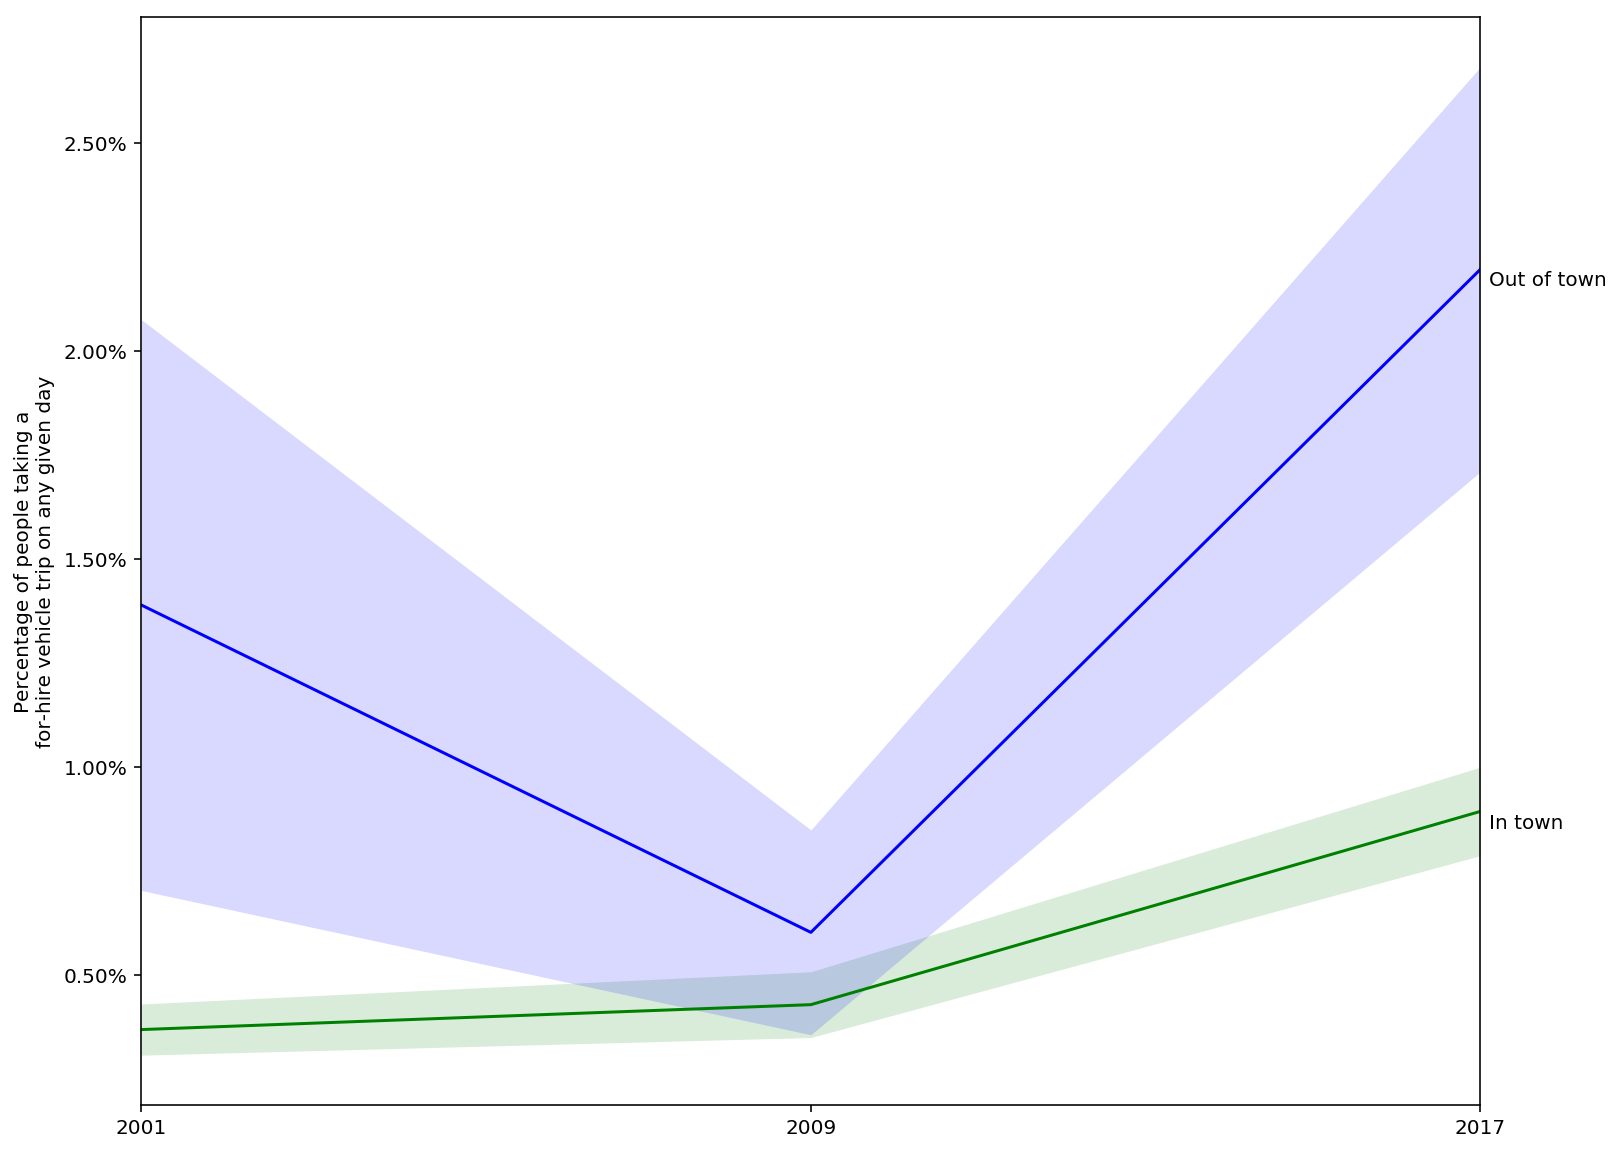

In [56]:
OUT_OF_TOWN = 'Out-of-town'
IN_TOWN = 'In town'

subsets01 = {}
subsets09 = {}
subsets17 = {}

for year, dta, subsets in [
    (2001, pers01, subsets01),
    (2009, pers09, subsets09),
    (2017, pers17, subsets17)
]:
    dta['outOfTown'] = dta.OUTOFTWN.replace({
        -7: np.nan,
        -8: np.nan,
        -9: np.nan,
        -1: False, # Appropriate skip: subject was at home at 4 AM on travel day.
        1: True,
        2: False
    })
    
    subsets['In town'] = dta.outOfTown == False
    subsets['Out of town'] = dta.outOfTown == True
    
# 95 subsets is None because this question was not asked in 1995
plotBySubsets(None, subsets01, subsets09, subsets17, colors={'Out of town': 'blue', 'In town': 'green'})

### What percentage of FHV trips are taken by people who are out of town?

And what percentage of people are out of town at any given time?

In [57]:
trips17 = trips17.merge(
    pers17[['HOUSEID', 'PERSONID', 'OUTOFTWN']],
    on=('HOUSEID', 'PERSONID'),
    validate='m:1',
    how='left'
)

In [58]:
# No missing data for OUTOFTWN in 2017
outOfTownTaxiProp = np.sum(trips17.loc[(trips17.OUTOFTWN == 1) & trips17.TRPTRANS.isin(TAXI_MODE[2017]), WEIGHTS[2017]]) /\
    np.sum(trips17.loc[trips17.TRPTRANS.isin(TAXI_MODE[2017]), WEIGHTS[2017]])
    
outOfTownTaxiSE = estReplicateSE(
    lambda i:\
        np.sum(trips17.loc[(trips17.OUTOFTWN == 1) & trips17.TRPTRANS.isin(TAXI_MODE[2017]), f'{REP_WEIGHTS[2017]}{i}']) /\
        np.sum(trips17.loc[trips17.TRPTRANS.isin(TAXI_MODE[2017]), f'{REP_WEIGHTS[2017]}{i}']),
    outOfTownTaxiProp,
    2017
)

outOfTownProp = np.sum(trips17.loc[(trips17.OUTOFTWN == 1), WEIGHTS[2017]]) /\
    np.sum(trips17[WEIGHTS[2017]])
    
outOfTownSE = estReplicateSE(
    lambda i:\
        np.sum(trips17.loc[(trips17.OUTOFTWN == 1), f'{REP_WEIGHTS[2017]}{i}']) /\
        np.sum(trips17[f'{REP_WEIGHTS[2017]}{i}']),
    outOfTownProp,
    2017
)

print(f'{outOfTownTaxiProp * 100:.2f} +/- {outOfTownTaxiSE * 100 * 1.96:.2f} of FHV trips are taken by people who are out of town')
print(f'{outOfTownProp * 100:.2f} +/- {outOfTownSE * 100 * 1.96:.2f} of all trips are taken by people who are out of town')

8.31 +/- 2.42 of FHV trips are taken by people who are out of town
2.50 +/- 0.15 of all trips are taken by people who are out of town


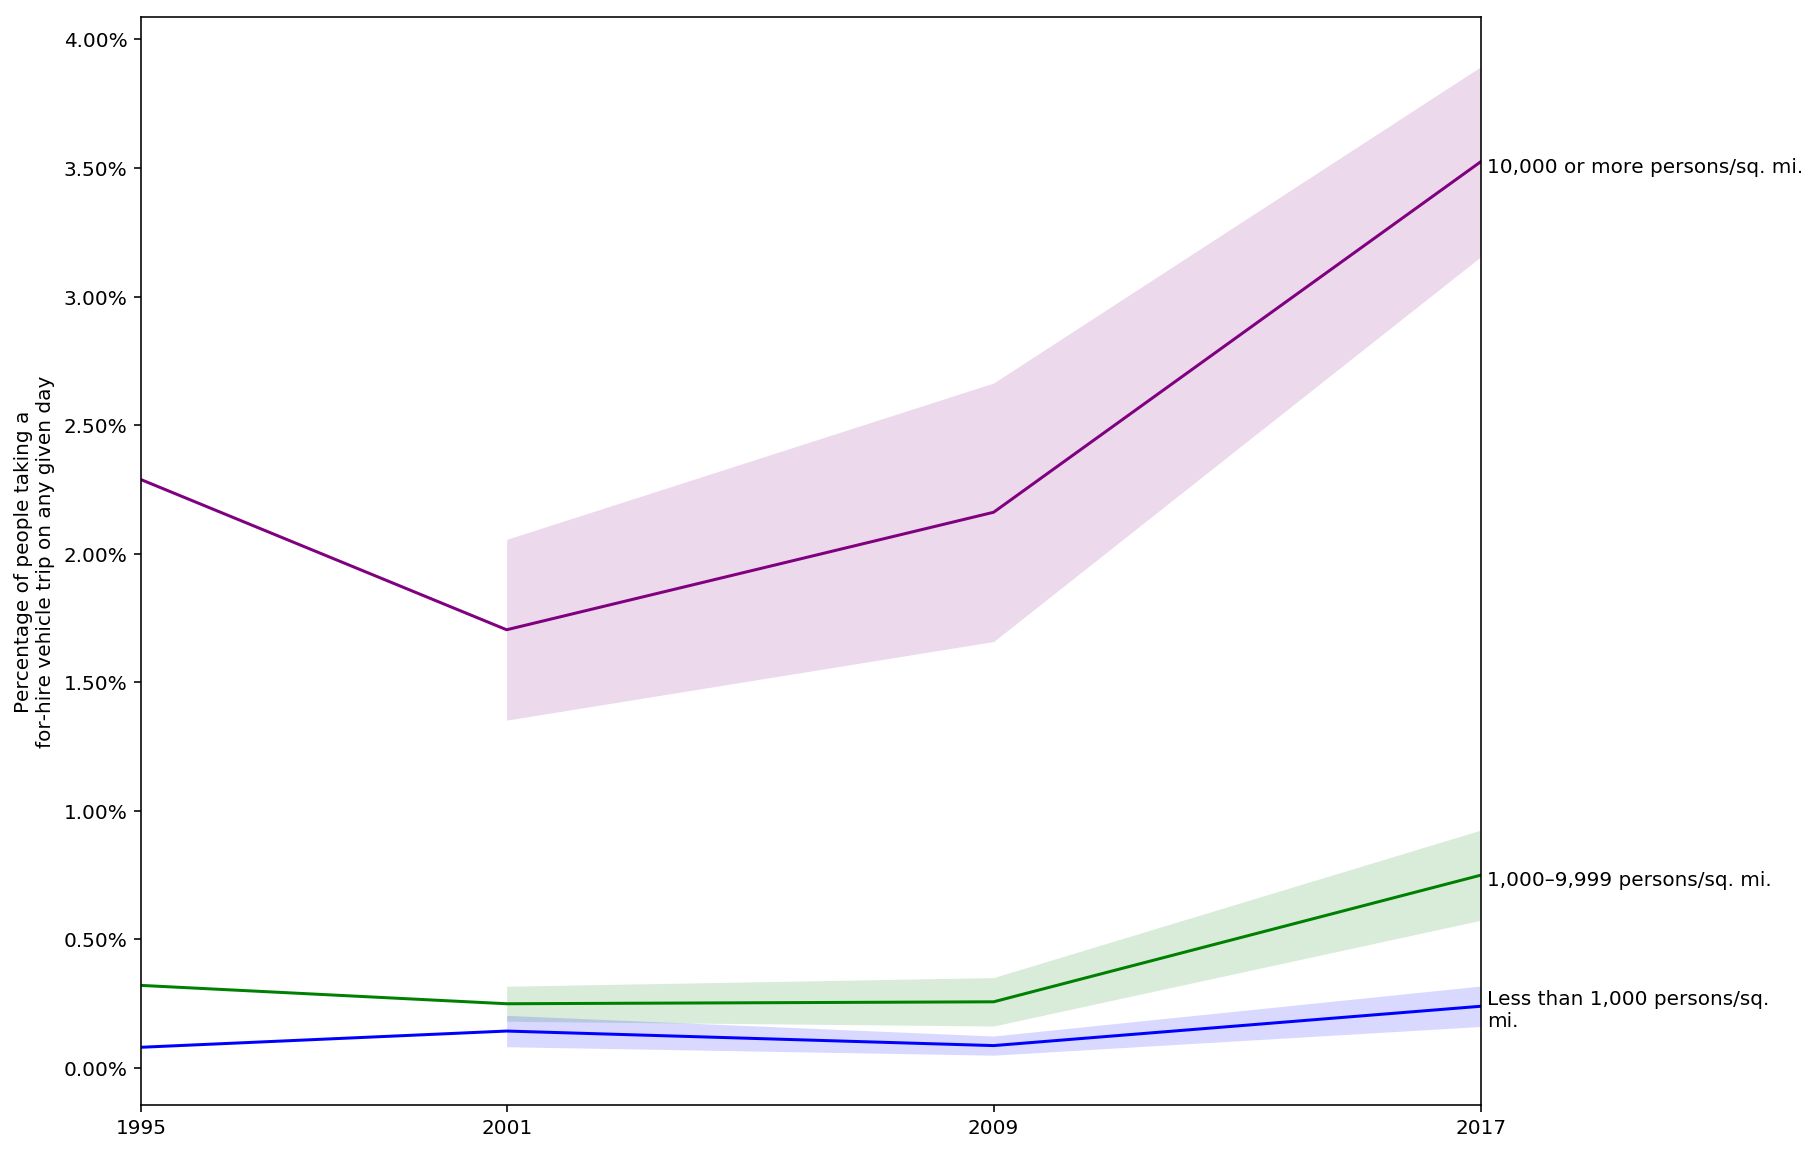

In [59]:
# Summarize density
for dta in [pers95, pers01, pers09, pers17]:
    dta['densCat'] = dta.HBPPOPDN.replace({
        50: 'Less than 1,000 persons/sq. mi.',
        300: 'Less than 1,000 persons/sq. mi.',
        750: 'Less than 1,000 persons/sq. mi.',
        1500: '1,000–9,999 persons/sq. mi.',
        3000: '1,000–9,999 persons/sq. mi.',
        7000: '1,000–9,999 persons/sq. mi.',
        17000: '10,000 or more persons/sq. mi.',
        30000: '10,000 or more persons/sq. mi.',
        999998: np.nan,
        -9: np.nan
    }).astype('category')
    
def toSubsets (col):
    subsets = {}
    for subsetLabel in col.cat.categories:
        subsets[subsetLabel] = col == subsetLabel
    return subsets
        
plotBySubsets(
    toSubsets(pers95.densCat),
    toSubsets(pers01.densCat),
    toSubsets(pers09.densCat),
    toSubsets(pers17.densCat),
    colors = {
        'Less than 1,000 persons/sq. mi.': 'blue',
        '1,000–9,999 persons/sq. mi.': 'green',
        '10,000 or more persons/sq. mi.': 'purple'
    }
)

plt.savefig('../fig/denstrend.pdf', bbox_inches='tight', title='For-hire vehicle usage by population density')

In [60]:
pers95.densCat.cat.categories

Index(['1,000–9,999 persons/sq. mi.', '10,000 or more persons/sq. mi.',
       'Less than 1,000 persons/sq. mi.'],
      dtype='object')

## Vehicle ownership

Weird pattern. https://twitter.com/mattwigway/status/1020077418860560384

1995: 47.70% +/- nan
2001: 32.92% +/- 10.35
2009: 53.18% +/- 10.85
2017: 32.61% +/- 9.87


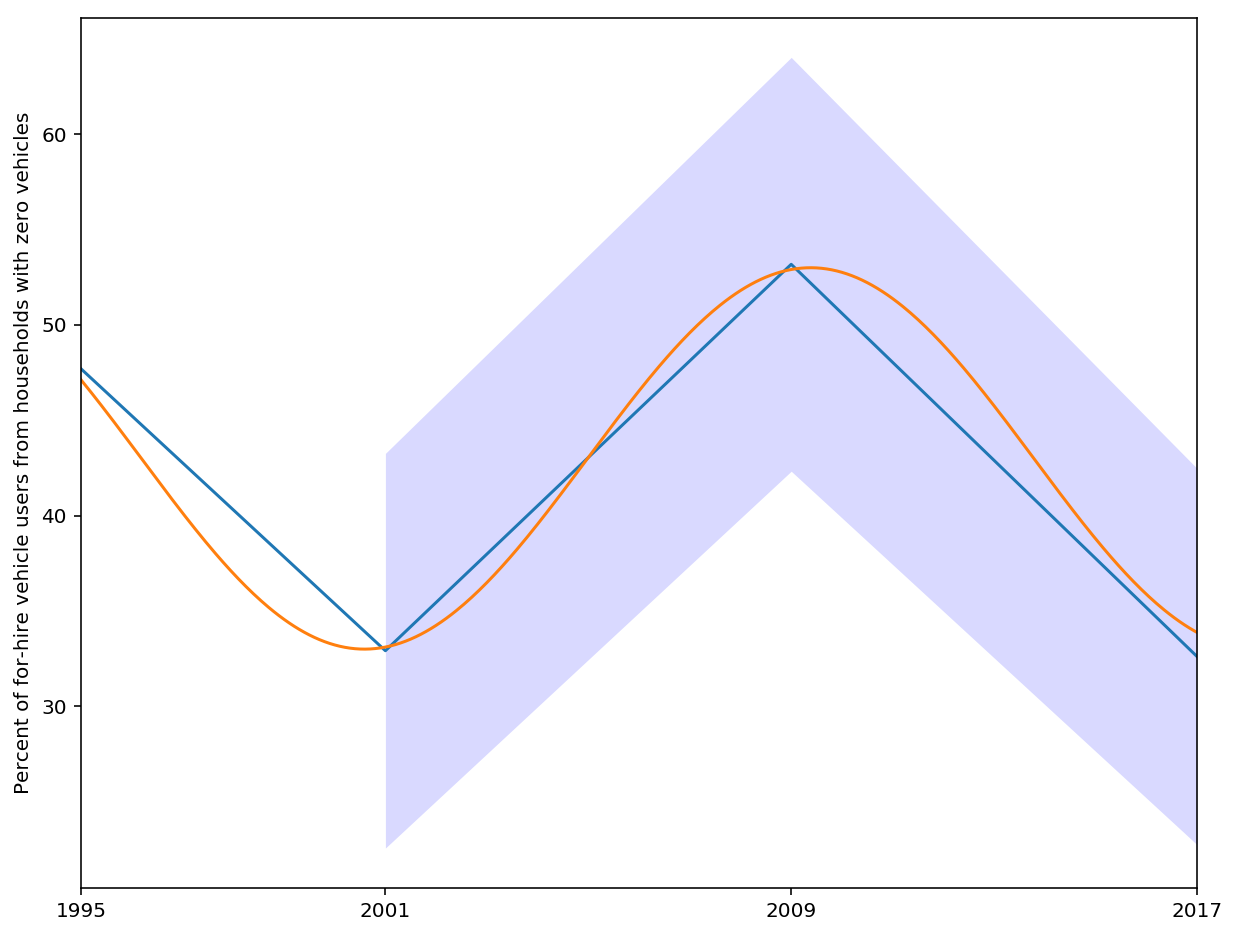

In [61]:
vehOwn = pd.DataFrame({'est': np.zeros(4), 'se': np.zeros(4)}, index=[1995, 2001, 2009, 2017])

for year, trps in [
    (1995, trips95),
    (2001, trips01),
    (2009, trips09),
    (2017, trips17)
]:
    taxiTrips = trps[trps.TRPTRANS.isin(TAXI_MODE[year])]
    est = np.sum(taxiTrips[taxiTrips.HHVEHCNT == 0][WEIGHTS[year]]) /\
        np.sum(taxiTrips[WEIGHTS[year]])
    se = estReplicateSE(
        lambda i: np.sum(taxiTrips[taxiTrips.HHVEHCNT == 0][f'{REP_WEIGHTS[year]}{i}']) /\
        np.sum(taxiTrips[f'{REP_WEIGHTS[year]}{i}']),
        est,
        year
    ) if year != 1995 else np.nan
    
    vehOwn.loc[year, 'est'] = est
    vehOwn.loc[year, 'se'] = se
    
    print(f'{year}: {est * 100:.2f}% +/- {se * 1.96 * 100:.2f}')

vehOwn *= 100
plt.figure(figsize=(10, 8))
plt.fill_between(vehOwn.index, vehOwn.est - vehOwn.se * 1.96, vehOwn.est + vehOwn.se * 1.96, color='blue', alpha=0.15, lw=0)
plt.plot(vehOwn.index, vehOwn.est)
plt.ylabel('Percent of for-hire vehicle users from households with zero vehicles')
plt.xticks([1995, 2001, 2009, 2017])
x = np.arange(1995, 2018, 0.05)
sy = np.sin(x / 2.8 + 6.5) * 10 + 43
plt.xlim(1995, 2017)
plt.plot(x, sy)

## Age of for-hire vehicle users in 2009

In [62]:
pers09['agecat'] = pd.cut(pers09.R_AGE.apply(lambda x: min(x, 89)), [0, 16, 20, 30, 40, 50, 60, 70, 80, 90], right=False)
pers17['agecat'] = pd.cut(pers17.R_AGE.apply(lambda x: min(x, 89)), [0, 16, 20, 30, 40, 50, 60, 70, 80, 90], right=False)

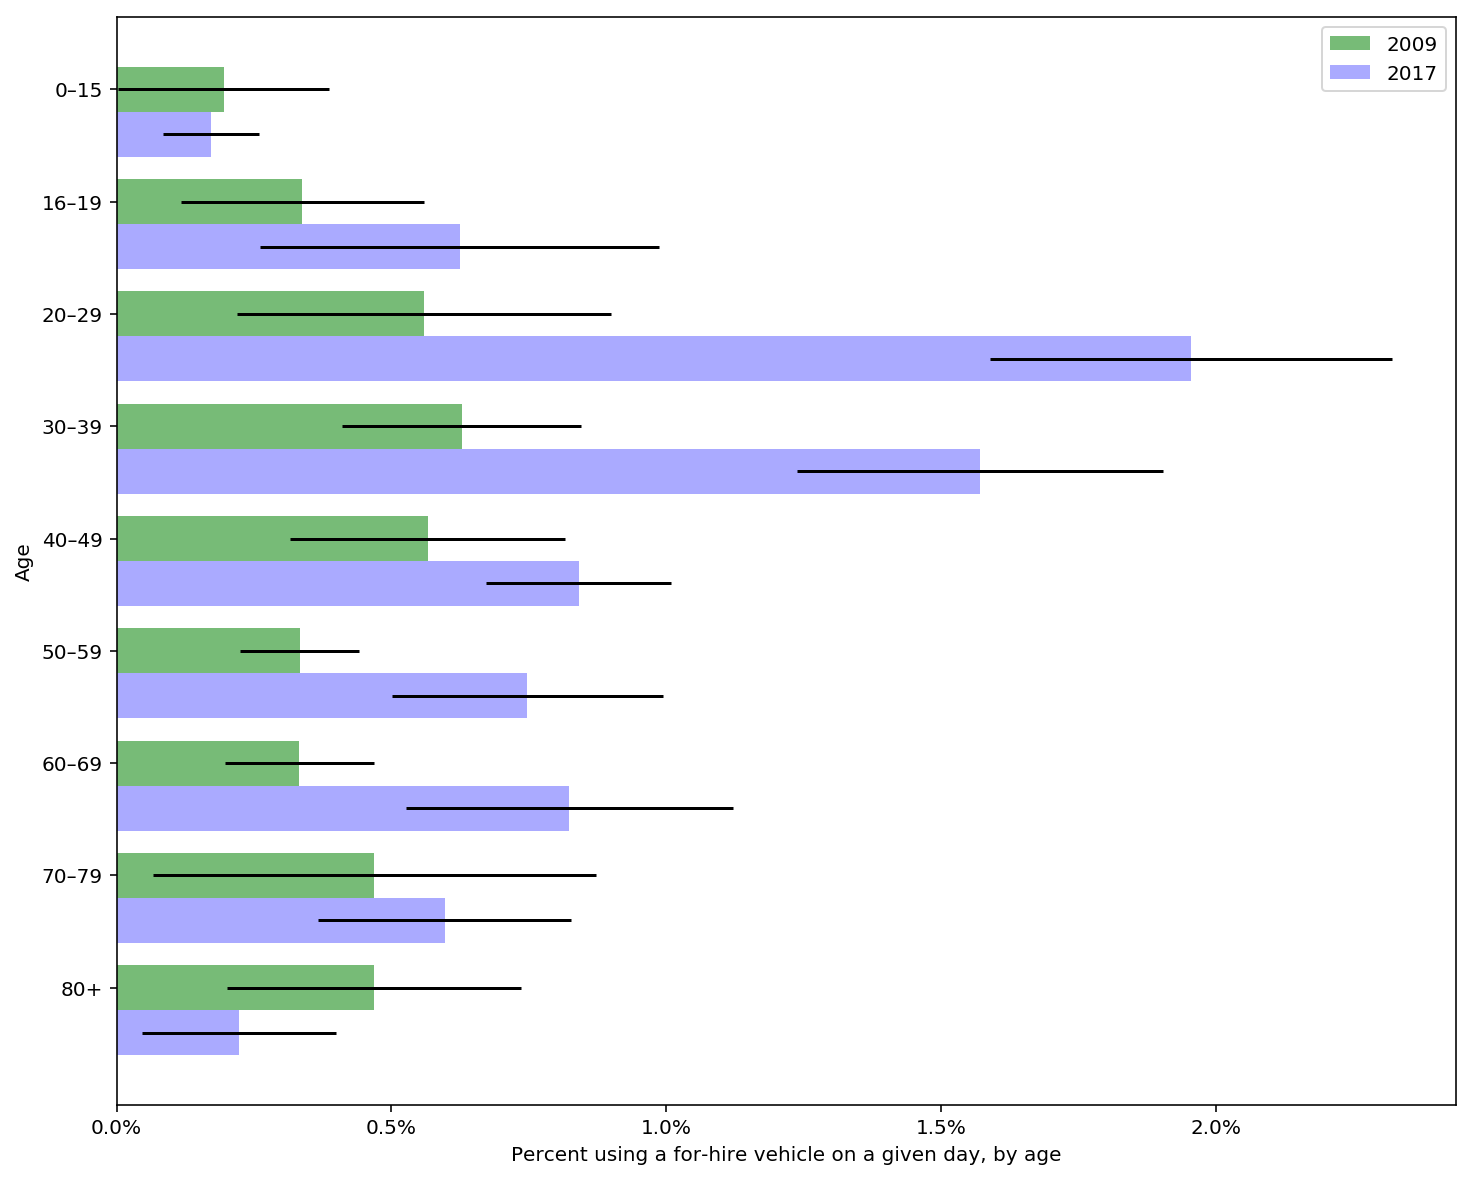

In [63]:
# percent using FHVs on a given day, by age
byAge09 = pers09.groupby('agecat').apply(lambda df: pd.Series({
    'est': np.sum(df[df.taxi][WEIGHTS[2009]]) / np.sum(df[WEIGHTS[2009]]),
    'se': estReplicateSE(
        lambda i: np.sum(df[df.taxi][f'{REP_WEIGHTS[2009]}{i}']) / np.sum(df[f'{REP_WEIGHTS[2009]}{i}']),
        np.sum(df[df.taxi][WEIGHTS[2009]]) / np.sum(df[WEIGHTS[2009]]),
        2009
    )
}))

byAge09['moe'] = byAge09.se * 1.96
byAge09 *= 100

byAge17 = pers17.groupby('agecat').apply(lambda df: pd.Series({
    'est': np.sum(df[df.taxi][WEIGHTS[2017]]) / np.sum(df[WEIGHTS[2017]]),
    'se': estReplicateSE(
        lambda i: np.sum(df[df.taxi][f'{REP_WEIGHTS[2017]}{i}']) / np.sum(df[f'{REP_WEIGHTS[2017]}{i}']),
        np.sum(df[df.taxi][WEIGHTS[2017]]) / np.sum(df[WEIGHTS[2017]]),
        2017
    )
}))

byAge17['moe'] = byAge17.se * 1.96
byAge17 *= 100

plt.figure(figsize=(12, 10))
plt.barh(-np.arange(len(byAge09)), byAge09.est, xerr=byAge09.moe, color=TAXI_COLOR, label='2009', height=0.4)
plt.barh(-np.arange(len(byAge17)) - 0.4, byAge17.est, xerr=byAge17.moe, color=GENERAL_COLOR, label='2017', height=0.4)

# confirm that both have the same index
assert np.all(byAge17.index == byAge09.index)

plt.yticks(-np.arange(len(byAge17)-0.4), [f'{x.left}–{x.right - 1}' if x.left != 80 else '80+' for x in byAge17.index])
plt.xticks(np.arange(0, 2.5, 0.5), [f'{x:.1f}%' for x in np.arange(0, 2.5, 0.5)])

plt.ylabel('Age')
plt.xlabel('Percent using a for-hire vehicle on a given day, by age')
plt.legend()

plt.savefig('../fig/agetrend.pdf')

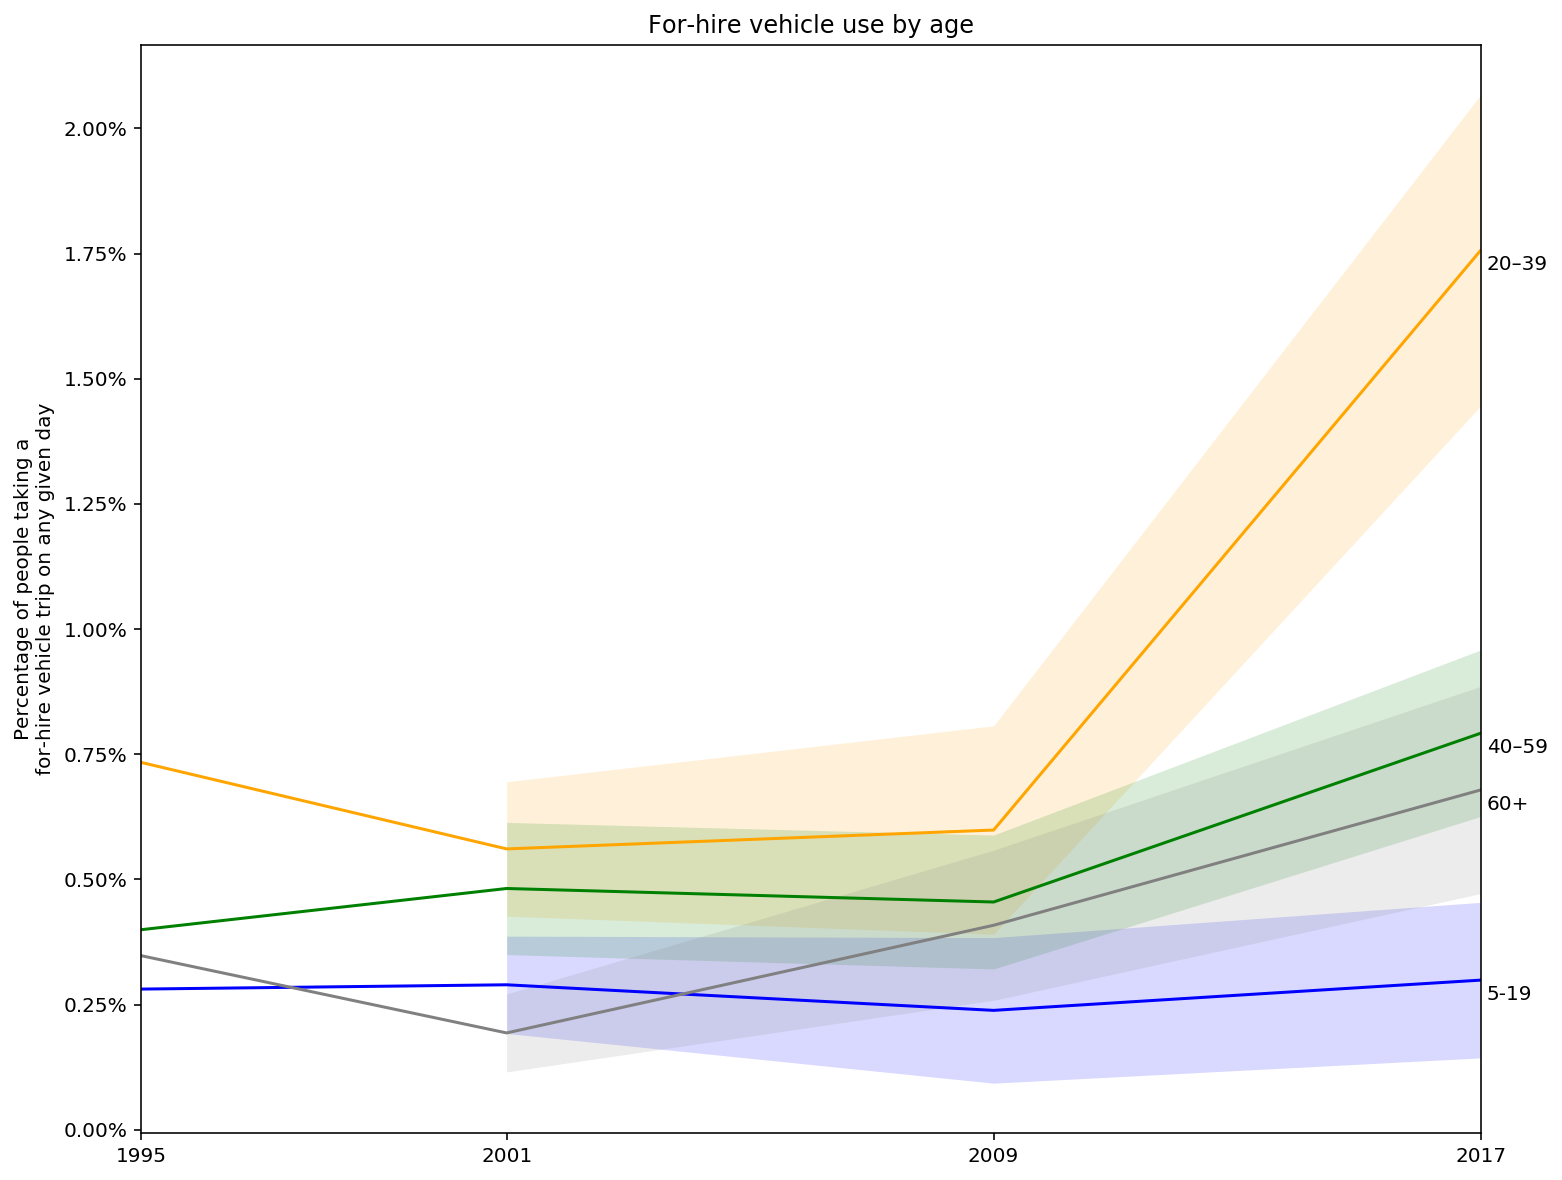

In [64]:
plotBySubsets(*[
    {
        '5-19': (dta.R_AGE < 20) & (dta.R_AGE >= 5),
        '20–39': (dta.R_AGE >= 20) & (dta.R_AGE < 40),
        '40–59': (dta.R_AGE >= 40) & (dta.R_AGE < 60),
        '60+': dta.R_AGE > 60
    } for dta in (pers95, pers01, pers09, pers17)],
    colors={
        '5-19': 'blue',
        '20–39': 'orange',
        '40–59': 'green',
        '60+': 'gray'
    },
    title='For-hire vehicle use by age',
    filename='../fig/agetrend.pdf'
)

## References

Wolter, K. (2007). Introduction to variance estimation. New York: Springer. Retrieved from https://link.springer.com/book/10.1007%2F978-0-387-35099-8